In [1]:
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import time
import os

from utils.dictionaries import types_fleet_original,propulsion_mapping,mapping

# Pandas vs Polars comparison

### Using polars

In [2]:
path = os.path.join("..","Data", "DGT")
original_fleet_path = os.path.join(path,"Exact_fleet","mat_2023.txt")

start_time = time.time()               
original_fleet_pl = pl.read_csv(original_fleet_path, separator='|', schema=types_fleet_original)
newest_matr = original_fleet_pl.select(pl.col("FECHA_MATR").max()).item()
elapsed_time = time.time() - start_time
print(f'The most recent registration is from the day {newest_matr}')
print(f"Elapsed time: {elapsed_time}")

The most recent registration is from the day 2023-12-29
Elapsed time: 135.59454011917114


In [4]:
start_time = time.time()               
oldest_matr = original_fleet_pl.select(pl.col("FECHA_MATR").min()).item()
elapsed_time = time.time() - start_time
print(f'The most anitque registration is from the day {oldest_matr}')
print(f"Elapsed time: {elapsed_time}")

The most anitque registration is from the day 1901-08-10
Elapsed time: 0.03117513656616211


### Using pandas

In [10]:
def reader(name, sep=',', columns=['FECHA_MATR'], parse_dates=None):
    chunksize = 10**4
    dates_col = parse_dates
    chunkreader = pd.read_csv(name, sep=sep, usecols=columns,chunksize=chunksize, 
                              on_bad_lines='skip', low_memory=False, parse_dates=dates_col) 
    #If bad lines not skipped we get an error bc of different types of data in the same columns
    #Columns (0,1,8,11,12,15,19,20,23,24,25,26,27,30,32,33,37,39,40,41,42,43,44) 

    for chunk in chunkreader:
        yield chunk

In [11]:
fechas = []
file = os.path.join(path,"Exact_fleet","mat_2023.txt")
start_time = time.time()
for chunk in reader(file,sep='|'):
    chunk['FECHA_MATR'] = pd.to_datetime(chunk['FECHA_MATR'], errors='coerce', dayfirst=True)
    fechas.append(chunk['FECHA_MATR'].max())

elapsed_time = time.time() - start_time
dates = pd.DataFrame({'NEWEST_MATR' : fechas})
newest_matr = dates['NEWEST_MATR'].max()
print(f'The most recent registration is from the day {newest_matr}')
print(f"Elapsed time: {elapsed_time}")

The most recent registration is from the day 2023-12-29 00:00:00
Elapsed time: 269.78870701789856


In [12]:
fechas = []
file = os.path.join(path,"Exact_fleet","mat_2023.txt")
start_time = time.time()
for chunk in reader(file,sep='|'):
    chunk['FECHA_MATR'] = pd.to_datetime(chunk['FECHA_MATR'], errors='coerce', dayfirst=True)
    fechas.append(chunk['FECHA_MATR'].min())

elapsed_time = time.time() - start_time
dates = pd.DataFrame({'NEWEST_MATR' : fechas})
oldest_matr = dates['NEWEST_MATR'].min()
print(f'The most recent registration is from the day {oldest_matr}')
print(f"Elapsed time: {elapsed_time}")

The most recent registration is from the day 1901-08-10 00:00:00
Elapsed time: 302.4455111026764


# Visualization of different columns of interest

### CAT_EURO

### TIPO_DISTINTIVO

In [51]:
path = os.path.join("..","Data", "DGT")
original_fleet_path = os.path.join(path,"Exact_fleet","mat_2023.txt")
          
distintivo = pl.scan_csv(original_fleet_path, separator='|', schema=types_fleet_original).select('TIPO_DISTINTIVO')
distintivo = distintivo.collect()['TIPO_DISTINTIVO'].value_counts().sort('TIPO_DISTINTIVO')
distintivo

TIPO_DISTINTIVO,count
str,u32
"""CERO""",445184
"""DISTINTIVO B""",10494638
"""DISTINTIVO C""",13321998
"""ECO""",1403495
"""SIN DISTINTIVO""",12225546


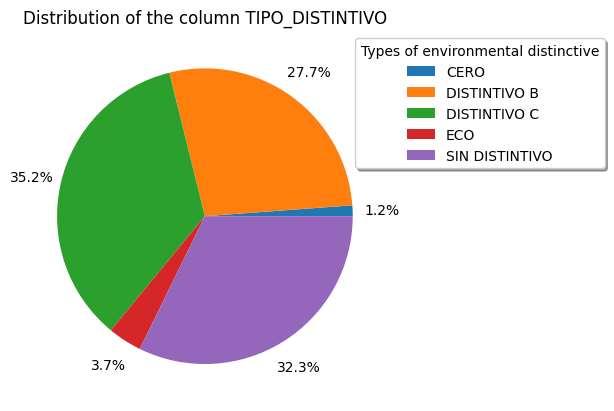

In [52]:
labels = distintivo['TIPO_DISTINTIVO'].to_list()
values = distintivo['count'].to_list()

fig, ax = plt.subplots()
ax.pie(values, autopct='%1.1f%%',
       pctdistance=1.2, labeldistance=0.6,startangle=0)

plt.legend(labels, title='Types of environmental distinctive',
           loc="upper right",  bbox_to_anchor=(1.1, 0, 0.5, 1),
           fancybox=True, shadow = True)
plt.title('Distribution of the column TIPO_DISTINTIVO')
output_path = os.path.join('..','Figures','Distribution_TIPO_DISTINTIVO.png')
plt.savefig(output_path, bbox_inches="tight")
plt.show()

### EMISIONES_CO2

In [41]:
path = os.path.join("..","Data", "DGT")
original_fleet_path = os.path.join(path,"Exact_fleet","mat_2023.txt")
          
emisiones_co2 = pl.scan_csv(original_fleet_path, separator='|', schema=types_fleet_original).select(['EMISIONES_CO2','FECHA_MATR'])
emisiones_co2 = emisiones_co2.collect()

In [37]:
null_perc = (100*emisiones_co2.select('EMISIONES_CO2').null_count()/emisiones_co2['EMISIONES_CO2'].len()).item()
print(f'{null_perc:.2f} % of this column is composed by null values')

52.91 % of this column is composed by null values


In [ ]:
null_co2 = emisiones_co2.filter(pl.col('EMISIONES_CO2').is_null())
not_null_CO2 = emisiones_co2.filter(pl.col('EMISIONES_CO2').is_not_null())

not_nulls = not_null_CO2.select('FECHA_MATR').get_columns()[0]
max_mat = not_nulls.max()
min_mat = not_nulls.min()

nulls = null_co2.select('FECHA_MATR').get_columns()[0]
max_mat2 = nulls.max()
min_mat2 = nulls.min()

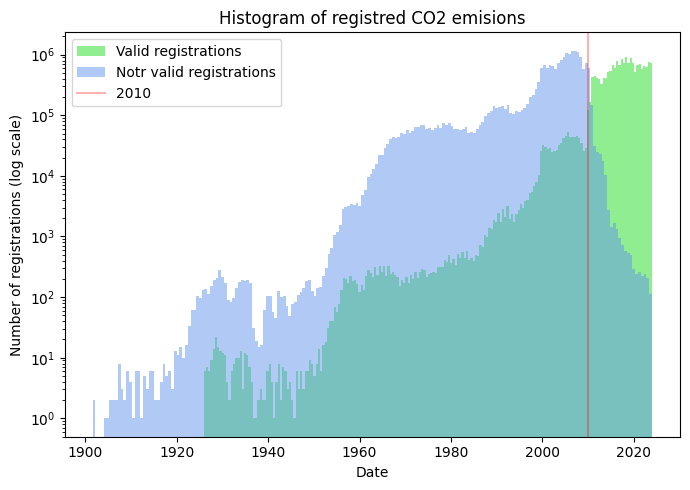

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(not_nulls,bins=200,range=(min_mat, max_mat),log=True,
    alpha=1,color="lightgreen",label="Valid registrations")

ax.hist(nulls,bins=200,range=(min_mat2, max_mat2),log=True,
    alpha=0.5,color="cornflowerblue",label="Not valid registrations")

ax.axvline(x=pd.Timestamp("2010-01-01"),color="red",alpha=0.3,label="2010")

ax.set_title("Histogram of registred CO2 emisions")
ax.set_xlabel("Date")
ax.set_ylabel("Number of registrations (log scale)")
ax.legend()

plt.tight_layout()
output_path = os.path.join('..','Figures','EMISIONESCO2_hist_log.png')
plt.savefig(output_path)
plt.show()

### EMISIONES_EURO

In [2]:
path = os.path.join("..","Data", "DGT")
original_fleet_path = os.path.join(path,"Exact_fleet","mat_2023.txt")       
# Columns that were explored 
columns= ['FECHA_MATR','FECHA_PRIM_MATR','EMISIONES_CO2','EMISIONES_EURO',
          'SUBTIPO_DGT','PROPULSION','CLASE_MATR','ALIMENTACION','CATELECT',
          'CONSUMO','PROVINCIA_MATR','CILINDRADA','POTENCIA','KW','TARA','PESO_MAX']

complete_park = pl.scan_csv(original_fleet_path, separator='|', schema=types_fleet_original).select(columns)
complete_park = complete_park.collect()

In [73]:
null_perc = (100*complete_park.select('EMISIONES_EURO').null_count()/complete_park['EMISIONES_EURO'].len()).item()
null_count = complete_park.select('EMISIONES_EURO').null_count().item()
print(f'{null_perc:.2f} % of this column is composed by null values')
print(f'That is equivalent to {null_count}')

12.65 % of this column is composed by null values
That is equivalent to 4792438


#### EMISIONES_EURO related with registration dates

In [3]:
cols = ['EMISIONES_EURO','FECHA_MATR','FECHA_PRIM_MATR']
null_dataframe = complete_park.select(cols).filter(pl.col('EMISIONES_EURO').is_null())
not_null_dataframe = complete_park.select(cols).filter(pl.col('EMISIONES_EURO').is_not_null())

In [4]:
matricula = not_null_dataframe.select('FECHA_MATR').get_columns()[0]
max_mat = matricula.max()
min_mat = matricula.min()

prim_matricula = not_null_dataframe.select('FECHA_PRIM_MATR').get_columns()[0]
max_primmat = prim_matricula.max()
min_primmat = prim_matricula.min()

diff = matricula - prim_matricula
s_days = diff.cast(pl.Duration).dt.total_days().cast(pl.Int32)/365
min_diff = s_days.min()
max_diff = s_days.max()

matricula2 = null_dataframe.select('FECHA_MATR').get_columns()[0]
max_mat2 = matricula2.max()
min_mat2 = matricula2.min()

prim_matricula2 = null_dataframe.select('FECHA_PRIM_MATR').get_columns()[0]
max_primmat2 = prim_matricula2.max()
min_primmat2 = prim_matricula2.min()

diff2 = matricula2 - prim_matricula2
s_days2 = diff2.cast(pl.Duration).dt.total_days().cast(pl.Int32)/365
min_diff2 = s_days2.min()
max_diff2 = s_days2.max()

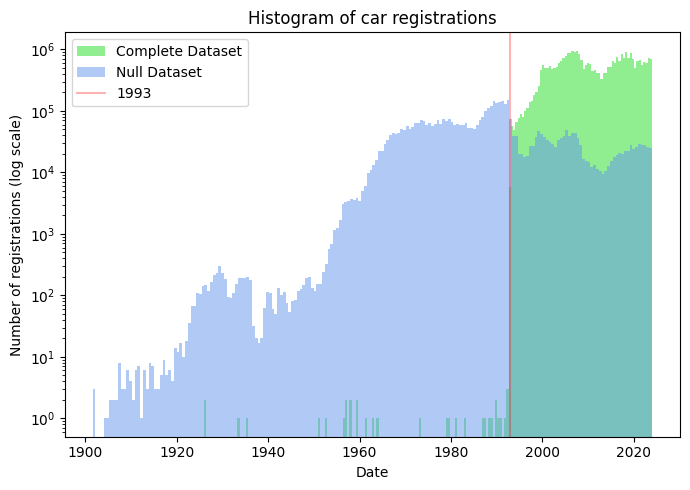

In [5]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(matricula,bins=200,range=(min_mat, max_mat),log=True,
    alpha=1,color="lightgreen",label="Complete Dataset")

ax.hist(matricula2,bins=200,range=(min_mat2, max_mat2),log=True,
    alpha=0.5,color="cornflowerblue",label="Null Dataset")

ax.axvline(x=pd.Timestamp("1993-01-01"),color="red",alpha=0.3,label="1993")

ax.set_title("Histogram of car registrations")
ax.set_xlabel("Date")
ax.set_ylabel("Number of registrations (log scale)")
ax.legend()

plt.tight_layout()
output_path = os.path.join('..','Figures','EMISIONES_EURO_date.png')
plt.savefig(output_path)
plt.show()

#### EMISIONES_EURO related with CLASE_MATR

In [101]:
def bar_plot(dataframe, nombre_columna,titulo, ax=None, threshold= 0.25, color = 'cornflowerblue'):
    values = dataframe[nombre_columna].value_counts().sort('count', descending=True).get_column('count').to_list()
    values_labels = dataframe[nombre_columna].value_counts().sort('count', descending=True).get_column(nombre_columna).to_list()

    for i, label in enumerate(values_labels):
        if label is None:
            values_labels[i] = 'None'

    others = 0
    percentages, labels = [], []

    for i, value in enumerate(values):
        percentage = 100 * value / sum(values)
        if percentage < threshold:
            others += percentage
        else:
            percentages.append(percentage)
            labels.append(values_labels[i])

    if others > 0:
        percentages.append(others)
        labels.append('Others')

    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 10))

    bars = ax.bar(labels, percentages, log=True, color = color)  
    
    ax.set_ylabel('Porcentage (log scale)')
    ax.set_title(titulo)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90, fontsize = 12)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', 
                ha='center', va='bottom', fontsize=12)

    if ax is None:
        plt.show()

In [99]:
complete_park = complete_park.with_columns(
    pl.col('CLASE_MATR').replace(mapping['CLASE_MATR']).alias("CLASE_MATR"),
    pl.col('SUBTIPO_DGT').replace(mapping['SUBTIPO_DGT']).alias("SUBTIPO_DGT"),
    pl.col('PROPULSION').replace(propulsion_mapping).alias("PROPULSION"))

null_dataframe = complete_park.filter(pl.col('EMISIONES_EURO').is_null())

not_null_dataframe = complete_park.filter(pl.col('EMISIONES_EURO').is_not_null())

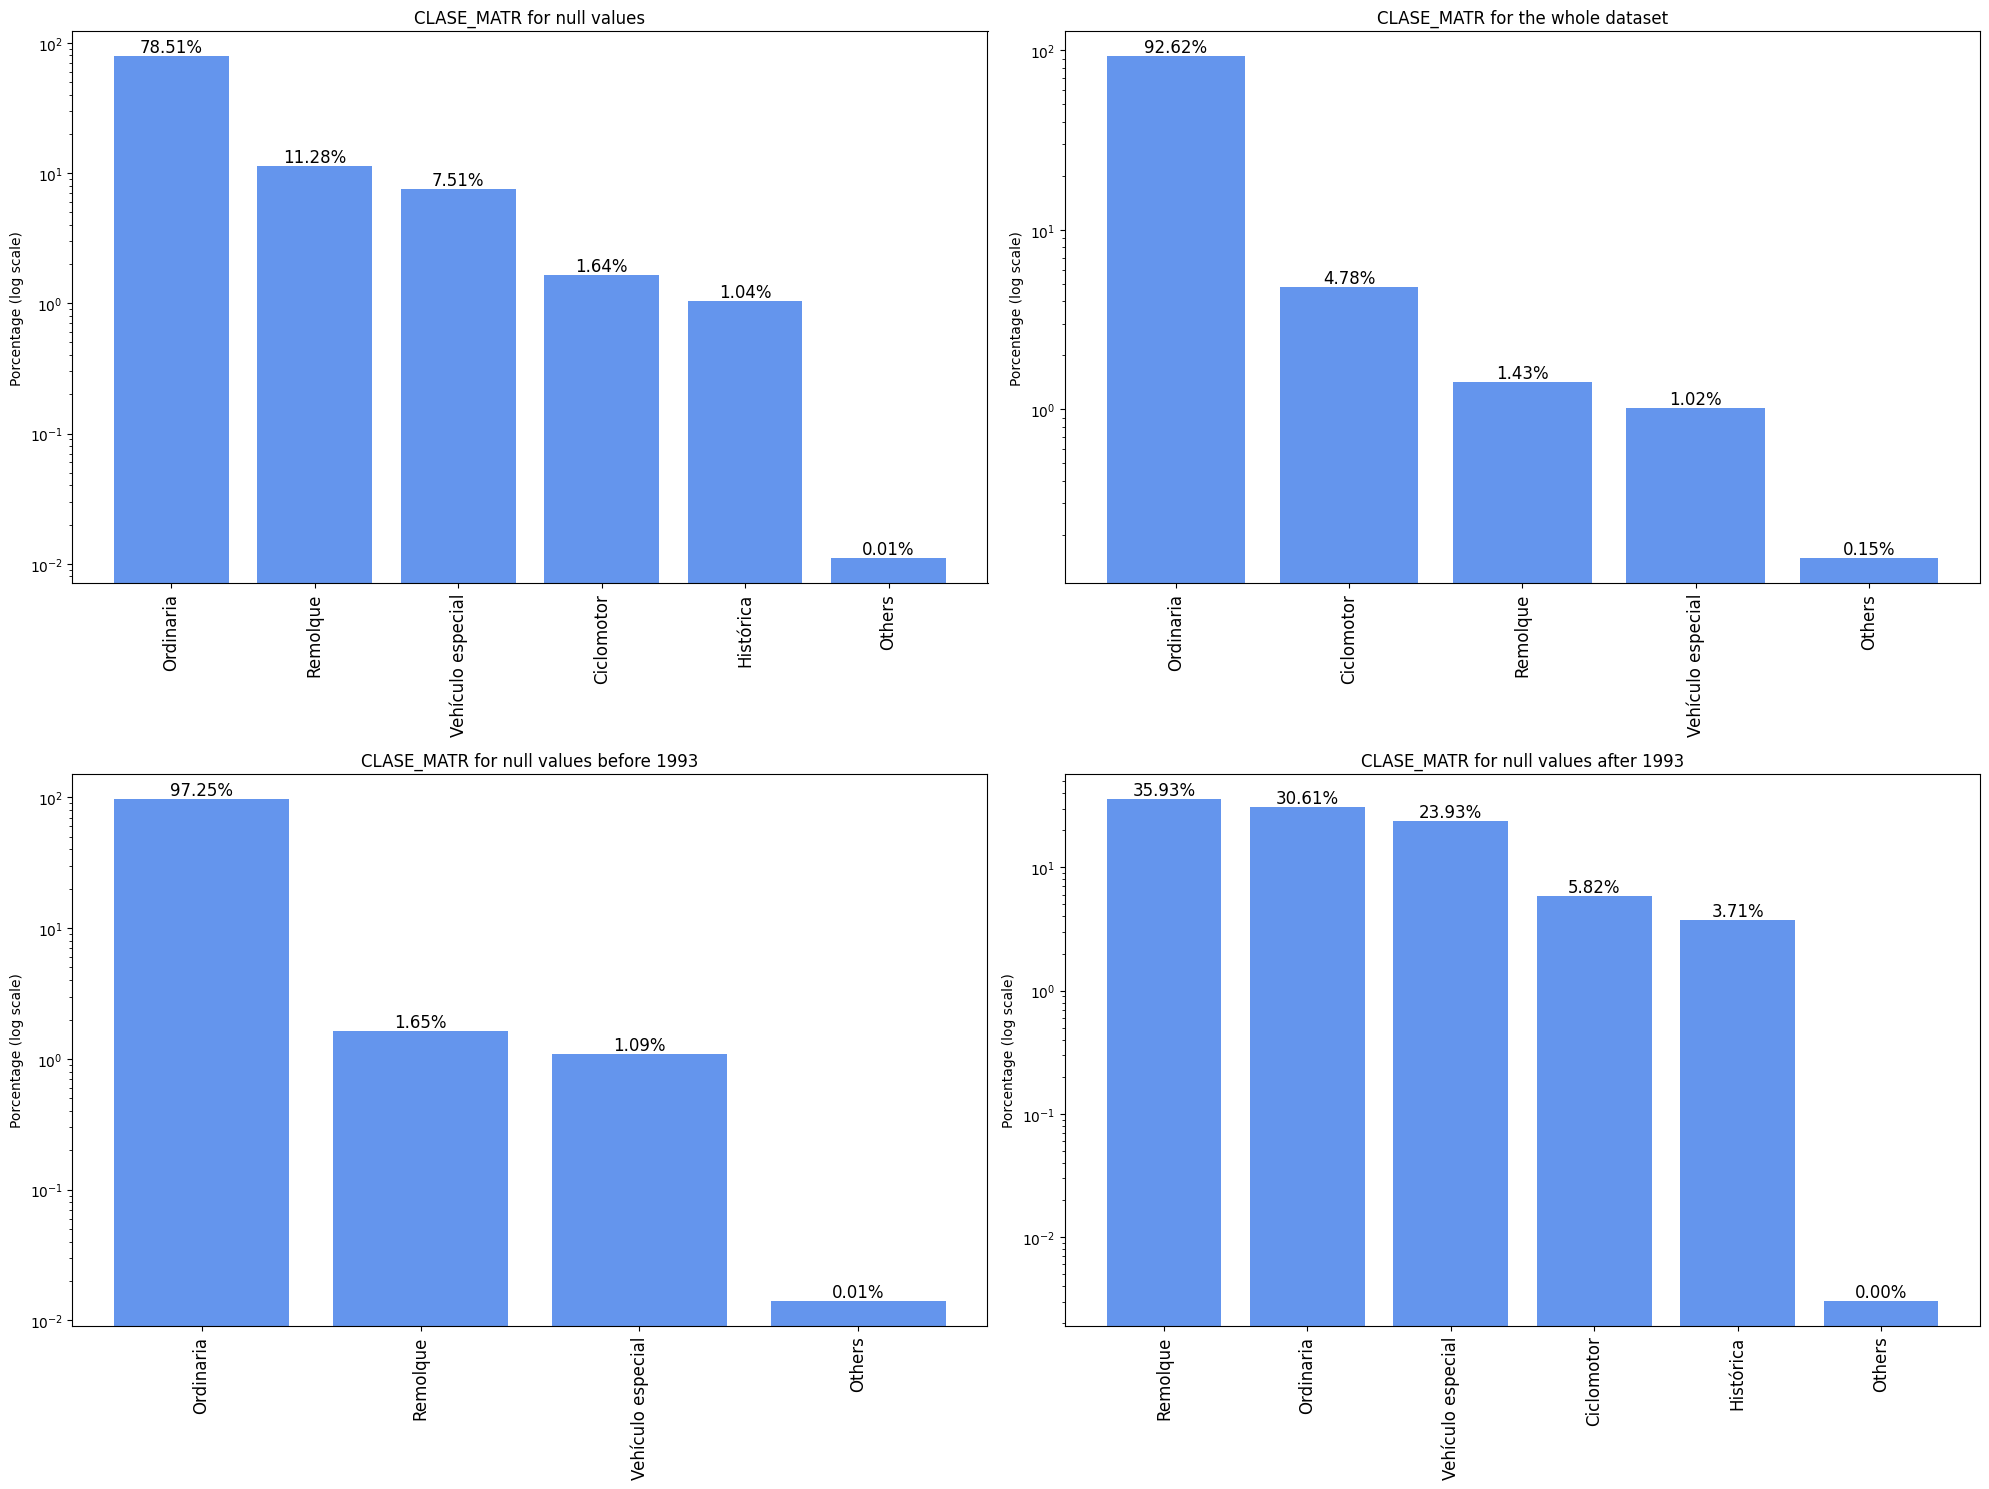

In [102]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

bar_plot(null_dataframe, 'CLASE_MATR','CLASE_MATR for null values', axes[0,0])
bar_plot(complete_park, 'CLASE_MATR','CLASE_MATR for the whole dataset', axes[0,1])
bar_plot(null_dataframe.filter(pl.col('FECHA_MATR').dt.year() < 1993), 'CLASE_MATR',
         'CLASE_MATR for null values before 1993', axes[1,0])
bar_plot(null_dataframe.filter(pl.col('FECHA_MATR').dt.year() > 1992), 'CLASE_MATR',
         'CLASE_MATR for null values after 1993', axes[1,1])

plt.tight_layout()
output_path = os.path.join('..','Figures','EMISIONES_EURO_CLASSE_MATR.png')
plt.savefig(output_path)
plt.show()

#### EMISIONES_EURO related with SUBTIPO_DGT

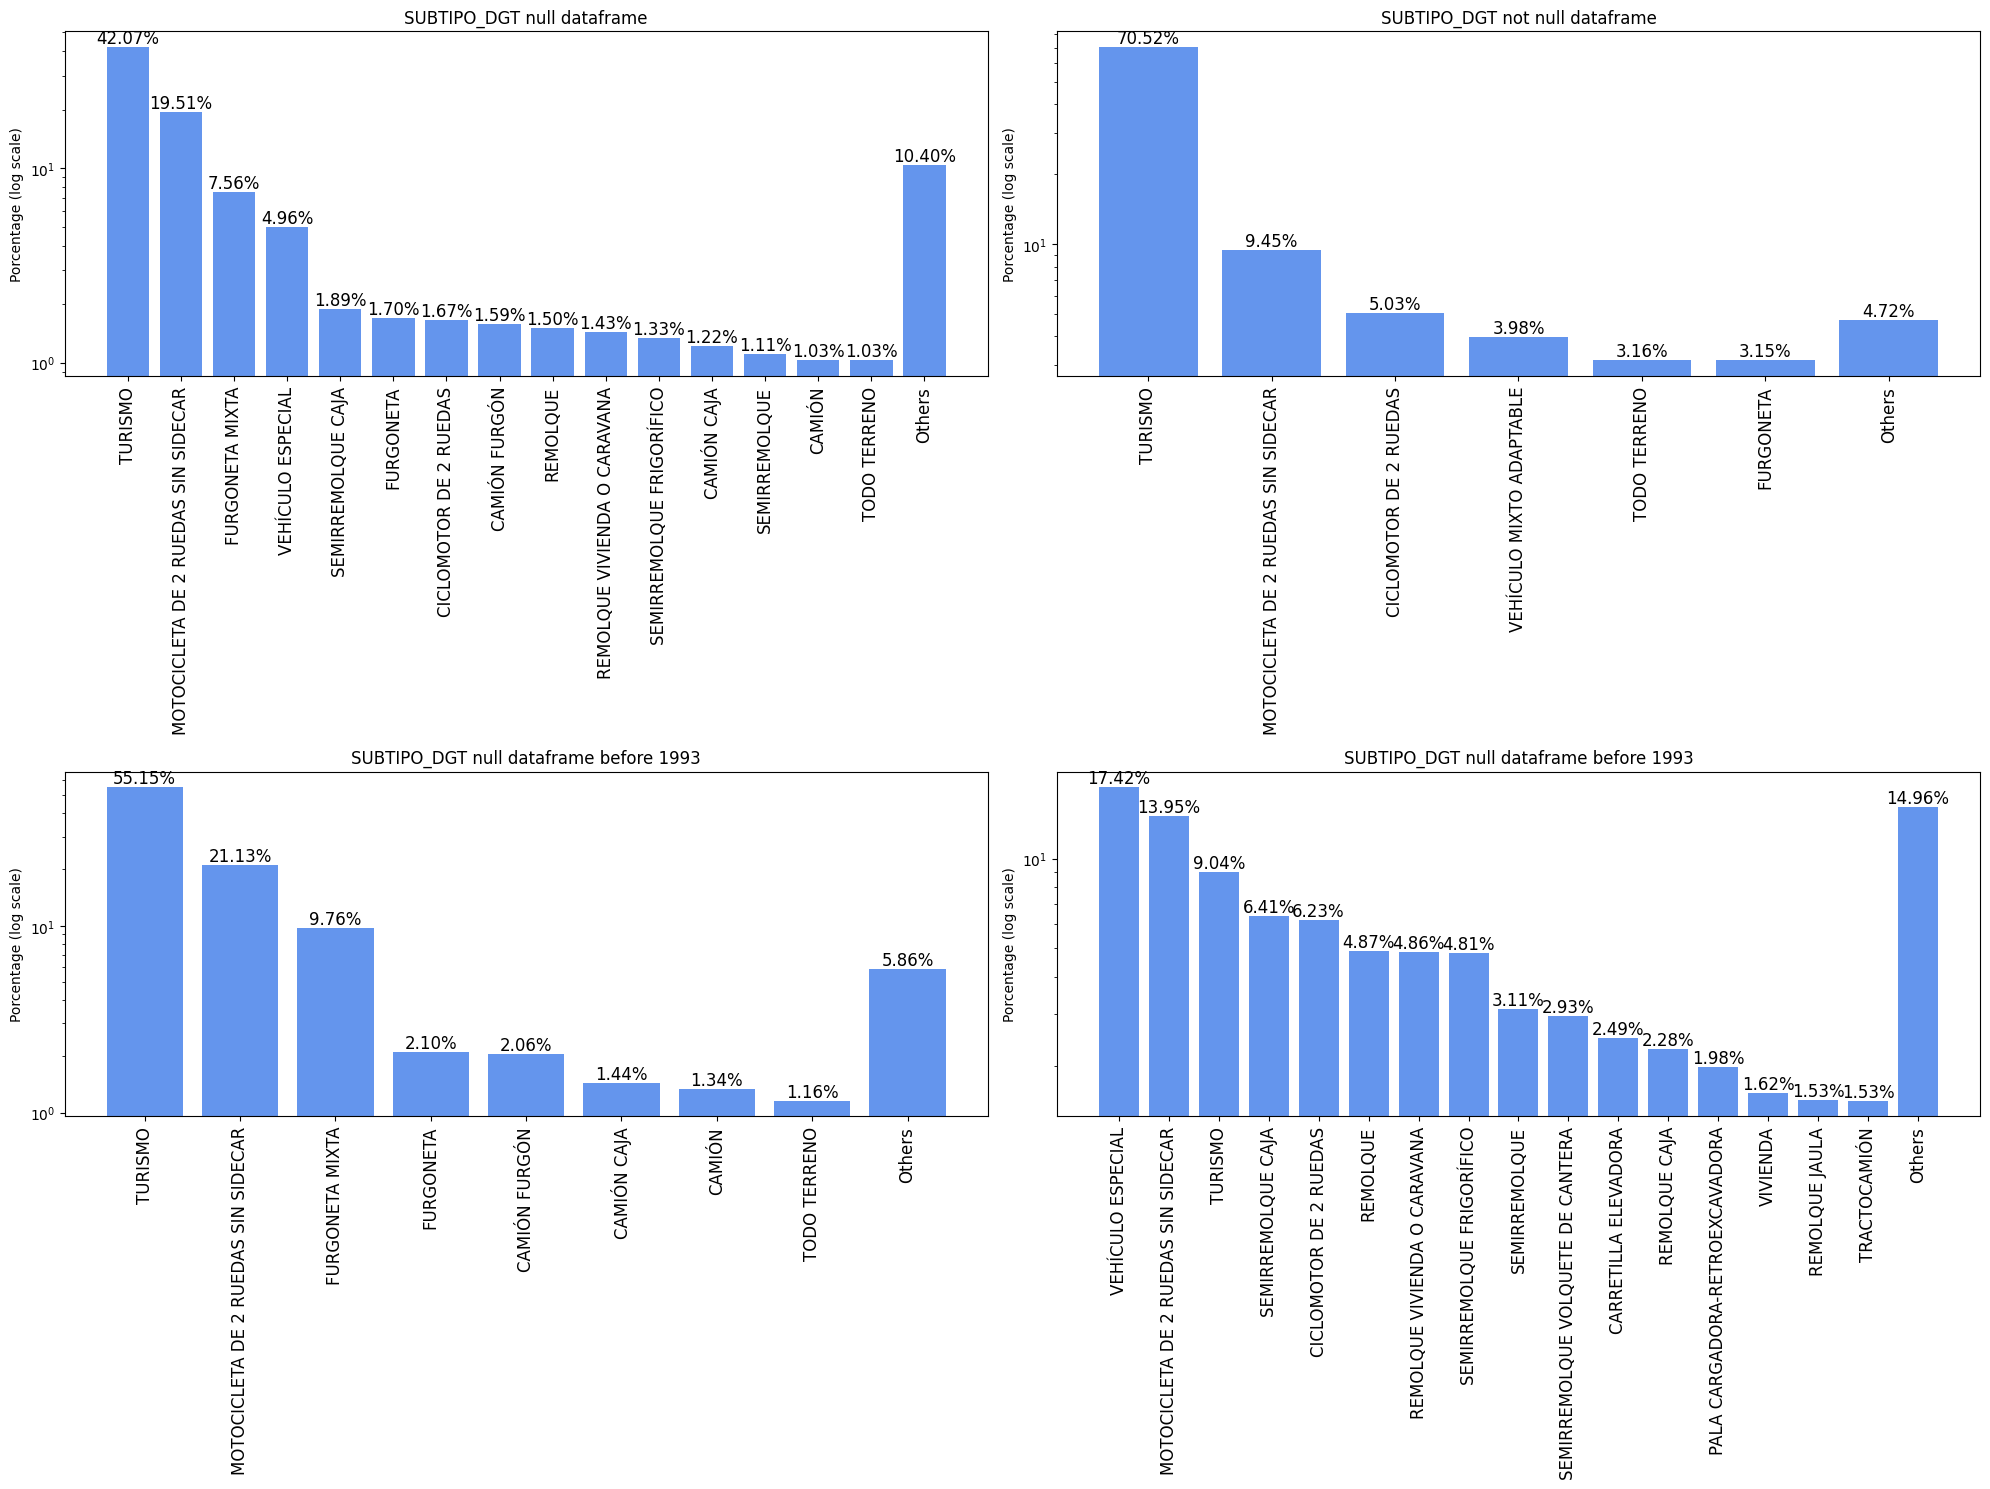

In [103]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

bar_plot(null_dataframe, 'SUBTIPO_DGT','SUBTIPO_DGT null dataframe', axes[0,0],1)
bar_plot(not_null_dataframe, 'SUBTIPO_DGT','SUBTIPO_DGT not null dataframe', axes[0,1],1)
bar_plot(null_dataframe.filter(pl.col('FECHA_MATR').dt.year() < 1993), 'SUBTIPO_DGT',
         'SUBTIPO_DGT null dataframe before 1993', axes[1,0],1)
bar_plot(null_dataframe.filter(pl.col('FECHA_MATR').dt.year() > 1993), 'SUBTIPO_DGT',
         'SUBTIPO_DGT null dataframe before 1993', axes[1,1],1.2)

plt.tight_layout()
output_path = os.path.join('..','Figures','EMISIONES_EURO_SUB_TIPO.png')
plt.savefig(output_path)
plt.show()

#### EMISIONES_EURO related with PROPULSION

In [106]:
complete_park['PROPULSION'].value_counts().sort('count', descending=True)

PROPULSION,count
str,u32
"""DIES""",18476120
"""GAS""",18400600
null,557132
"""ELEC""",284854
"""GLP""",139957
…,…
"""H""",162
"""ETH""",77
"""BIOMET""",51


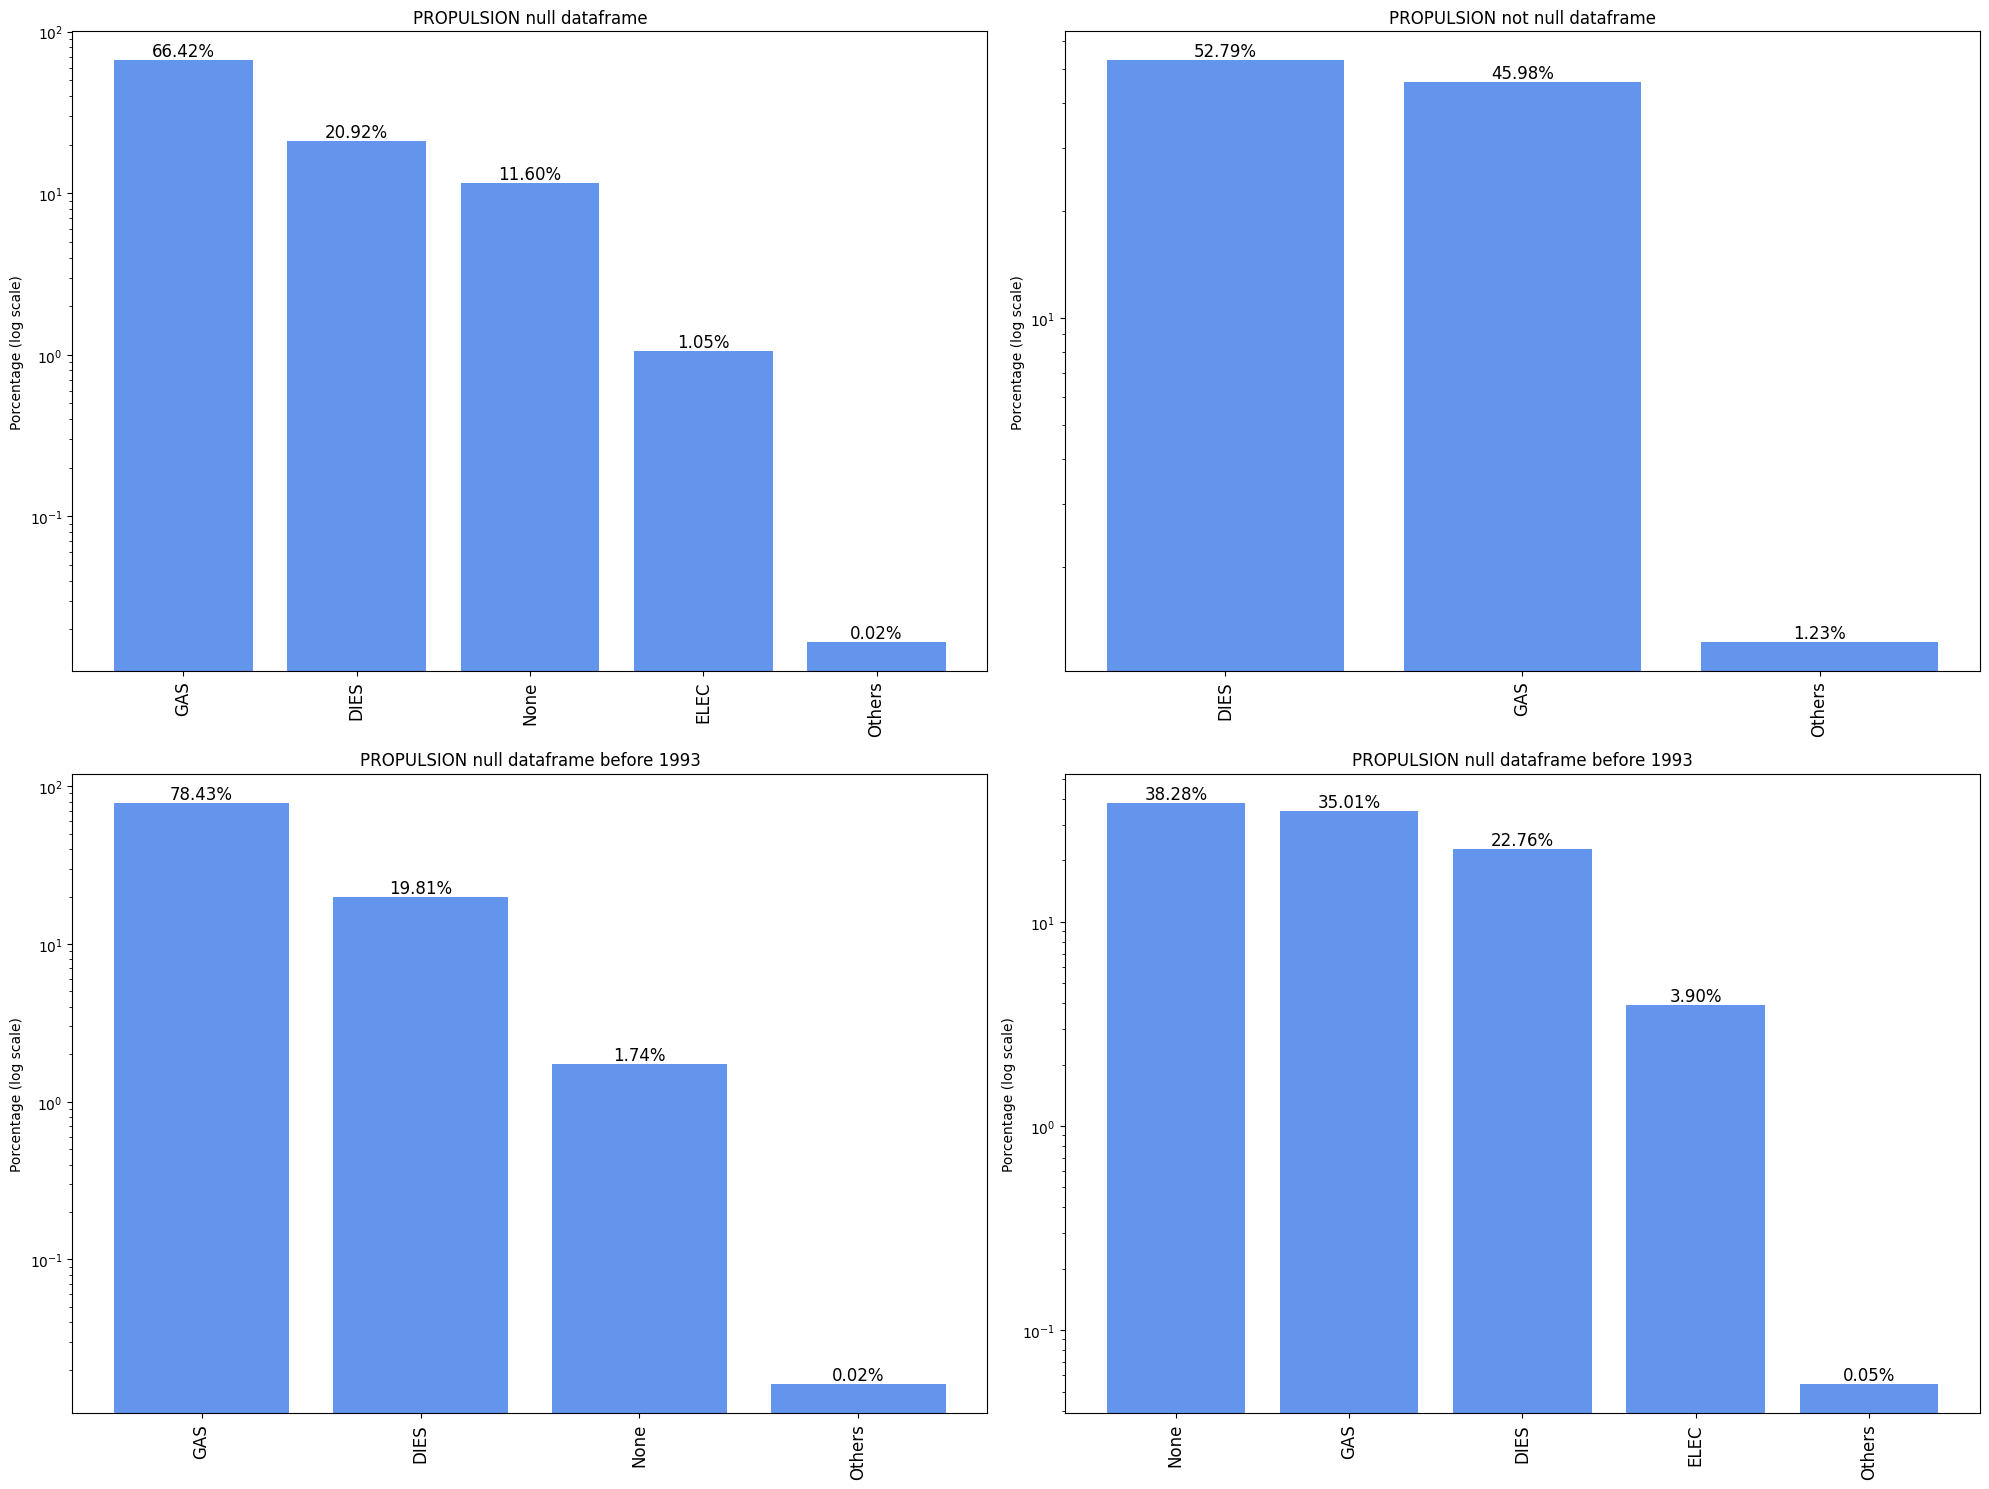

In [104]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

bar_plot(null_dataframe, 'PROPULSION','PROPULSION null dataframe', axes[0,0],1)
bar_plot(not_null_dataframe, 'PROPULSION','PROPULSION not null dataframe', axes[0,1],1)
bar_plot(null_dataframe.filter(pl.col('FECHA_MATR').dt.year() < 1993), 'PROPULSION',
         'PROPULSION null dataframe before 1993', axes[1,0],1)
bar_plot(null_dataframe.filter(pl.col('FECHA_MATR').dt.year() > 1993), 'PROPULSION',
         'PROPULSION null dataframe before 1993', axes[1,1],1.2)

plt.tight_layout()
output_path = os.path.join('..','Figures','EMISIONES_EURO_PROPULSION.png')
plt.savefig(output_path)
plt.show()

#### Categories inside EMISIONES_EURO

In [ ]:
counts_euro = complete_park['EMISIONES_EURO'].value_counts().sort('count', descending=True)
total = counts_euro['count'].len()
mean = counts_euro.mean()['count'].item()
mean_counts = counts_euro.filter(pl.col('count')>mean)['count'].len()
print(f'Total number of categories present in the dataset: {total}')
print(f'Categories with more appearances than the average appearances: {mean_counts}')

Total number of categories present in the dataset: 179
Categories with more appearances than the average appearances: 16


In [141]:
m10= counts_euro.filter(pl.col('count')<10)['count'].len()
m100 = counts_euro.filter(pl.col('count')<100)['count'].len()
print(f'Categories present in the dataset with less tha 100 appeappearances: {m10}')
print(f'Categories present in the dataset with less tha 100 appeappearances: {m100}')


Categories present in the dataset with less tha 100 appeappearances: 59
Categories present in the dataset with less tha 100 appeappearances: 95


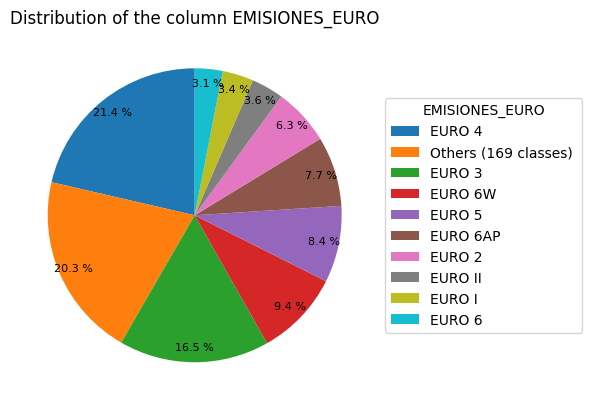

In [139]:
threshold_pct = 3.0
title         = "Distribution of the column EMISIONES_EURO"
output_path   = os.path.join("..", "Figures", "EMISIONES_EURO_DIST.png")

counts_euro = counts_euro.filter(pl.col('EMISIONES_EURO').is_not_null()).with_columns(pl.col("count").cast(pl.Int64))

counts_euro = counts_euro.with_columns((pl.col("count") / pl.sum("count") * 100).alias("pct"))

major = counts_euro.filter(pl.col("pct") >= threshold_pct)
minor = counts_euro.filter(pl.col("pct") <  threshold_pct)
others_count = minor['count'].len()

if minor.height > 0:
    others_row = pl.DataFrame({
        "EMISIONES_EURO": [f"Others ({others_count} classes) "],
        "count":          [minor["count"].sum()], 
        "pct":            [minor["pct"].sum()],
    })
    major = major.vstack(others_row)

major = major.sort("pct", descending=True)

labels = major["EMISIONES_EURO"].to_list()
sizes  = major["count"].to_list()

def autopct_fmt(p):
    return f"{p:.1f} %" if p >= threshold_pct else ""

fig, ax = plt.subplots(figsize=(6, 6))
wedges, *_ = ax.pie(
    sizes,
    startangle=90,
    autopct=autopct_fmt,
    pctdistance=0.9,
    textprops={"fontsize": 8}
)

ax.set_title(title)
ax.legend(
    wedges, labels,
    title="EMISIONES_EURO",
    loc="center left", bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

La primera vez que se usó un distintivo EURO para las emisiones fue el 1992, asi que supomgo que hasta el 1993 no se actualizaron los registros

Ahora sabemos que los coches más antiguos del 1993 no tenian la equivalencia a EURO, habria que mirar que tipo de distintivo les pusieron y ver que pasa con los coches que son nuevos pero aún asi no tienen la homologacion EURO (hay que ver que tipo de vehciulos son)

#### Por el tipo de vehiculo

In [7]:
def bar_plot(dataframe, nombre_columna,titulo, ax=None, threshold= 0.01):
    values = dataframe[nombre_columna].value_counts().sort('count', descending=True).get_column('count').to_list()
    values_labels = dataframe[nombre_columna].value_counts().sort('count', descending=True).get_column(nombre_columna).to_list()

    for i, label in enumerate(values_labels):
        if label is None:
            values_labels[i] = 'None'

    others = 0
    percentages, labels = [], []

    for i, value in enumerate(values):
        percentage = 100 * value / sum(values)
        if percentage < threshold:
            others += percentage
        else:
            percentages.append(percentage)
            labels.append(values_labels[i])

    if others > 0:
        percentages.append(others)
        labels.append('Others')

    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 10))

    bars = ax.bar(labels, percentages, log=True)  
    
    ax.set_ylabel('Porcentage del parque de vehiculos')
    ax.set_title(titulo)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', 
                ha='center', va='bottom', fontsize=8)

    if ax is None:
        plt.show()

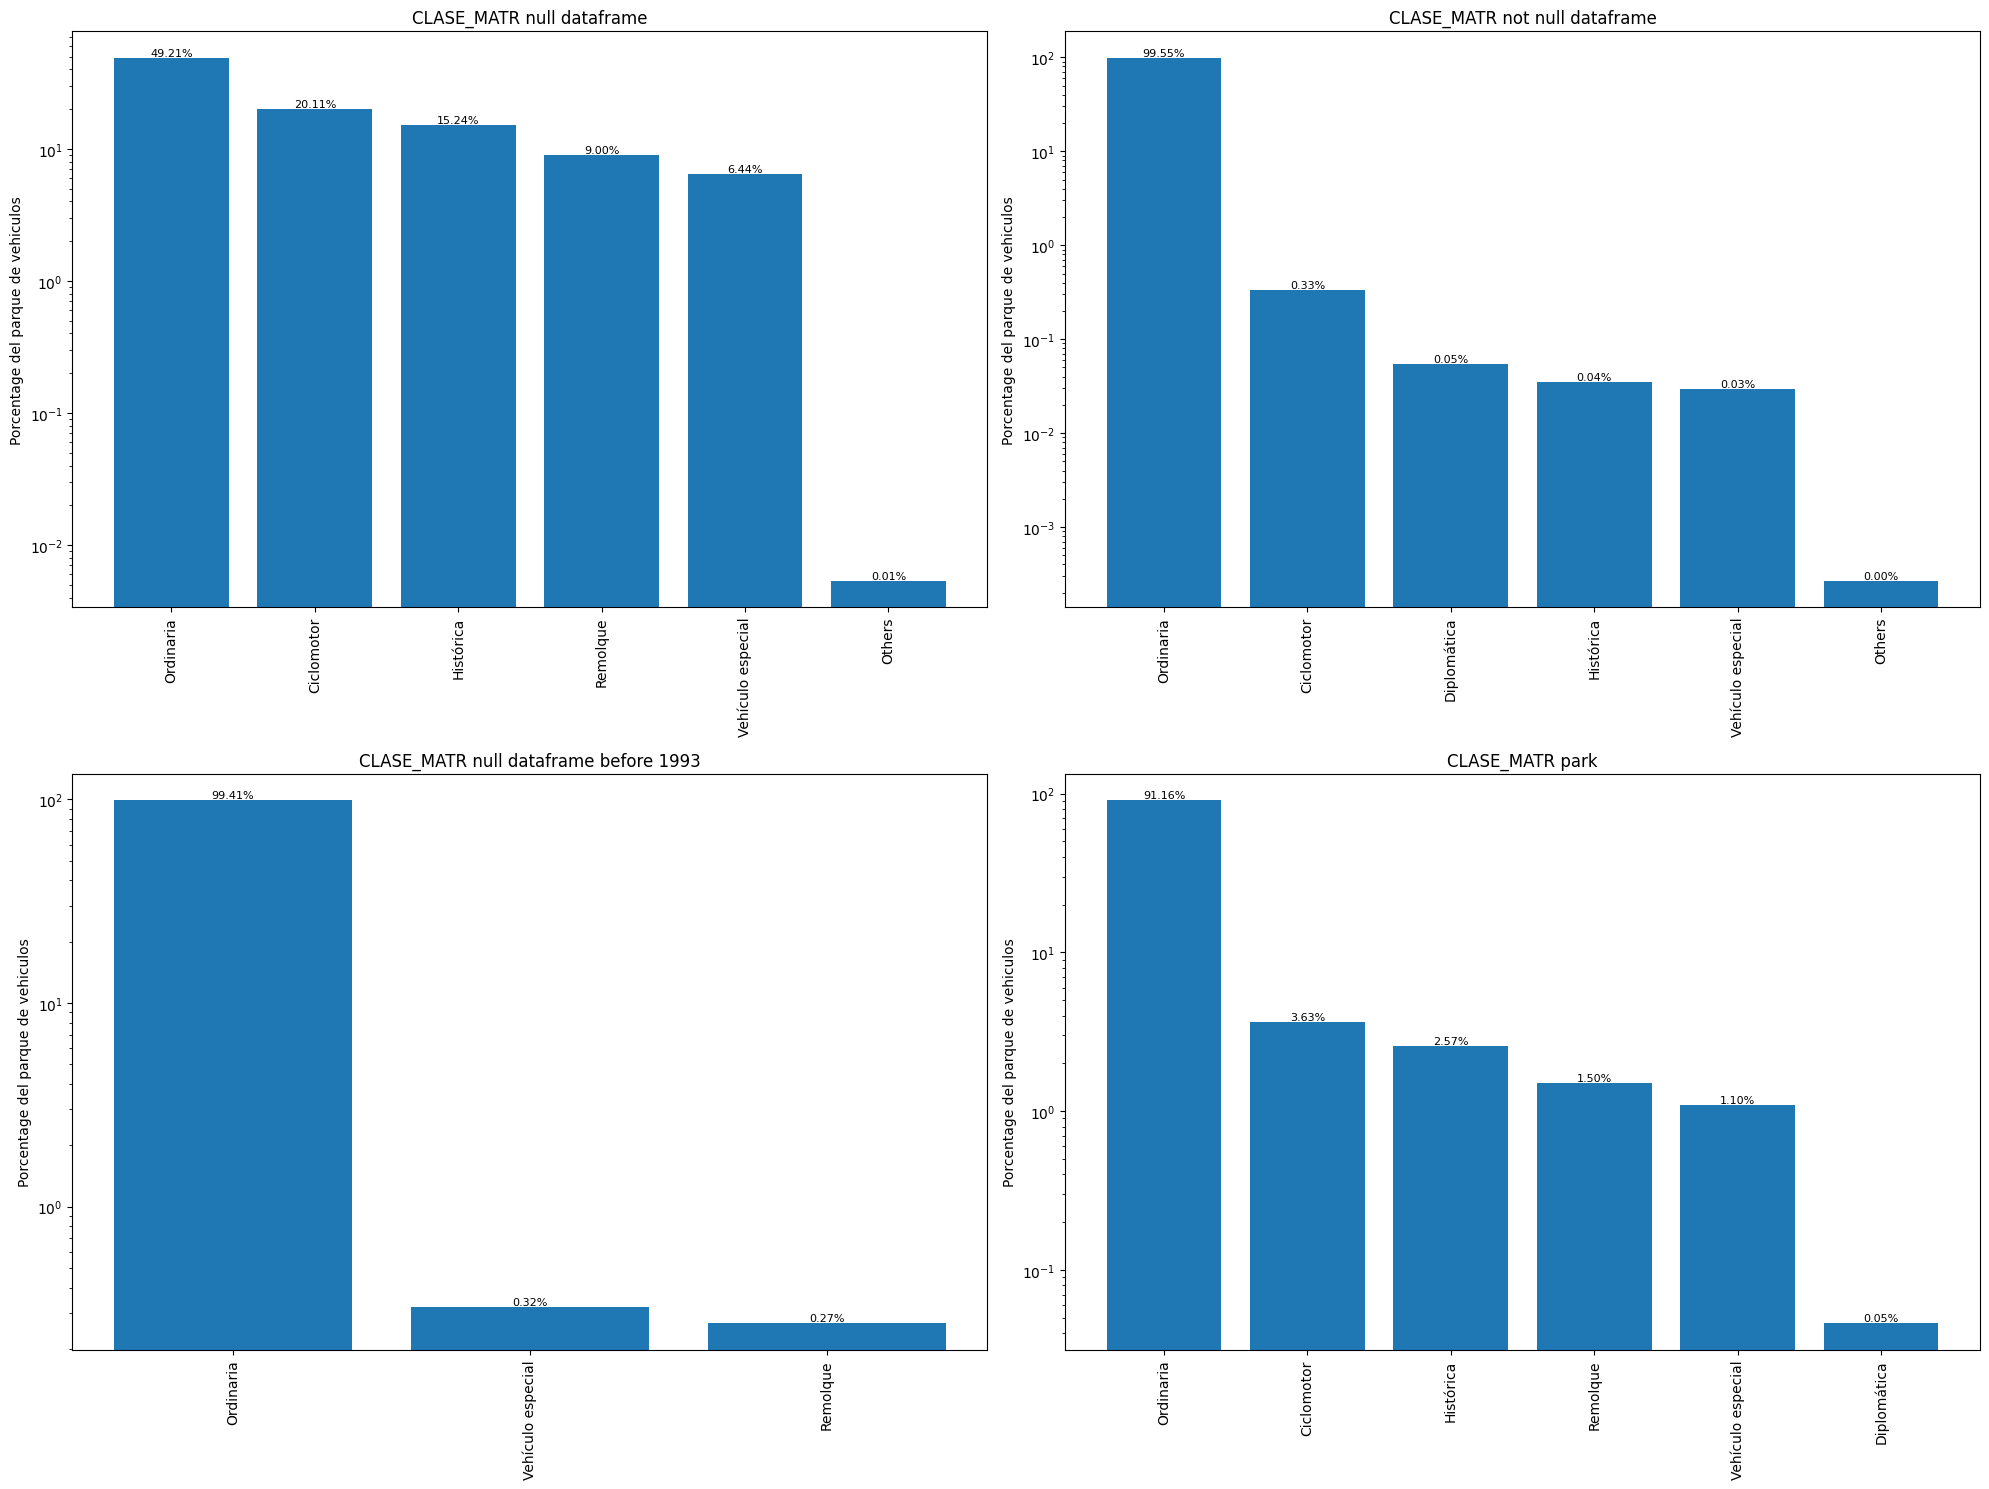

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

bar_plot(null_dataframe, 'CLASE_MATR','CLASE_MATR null dataframe', axes[0,0])
bar_plot(not_null_dataframe, 'CLASE_MATR','CLASE_MATR not null dataframe', axes[0,1])
bar_plot(park, 'CLASE_MATR','CLASE_MATR park', axes[1,1])
bar_plot(null_dataframe.filter(pl.col('FECHA_MATR').dt.year() < 1993), 'CLASE_MATR',
         'CLASE_MATR null dataframe before 1993', axes[1,0])

plt.tight_layout()
plt.show()

Hay muchas menos ordinarias. lo cual nos indica que los vehciulos diferentes son más propensos a no tener los datos de emisiones por lo tanto algo tiene que ver con el tipo de vehículo

#### Por subtipo vehículo

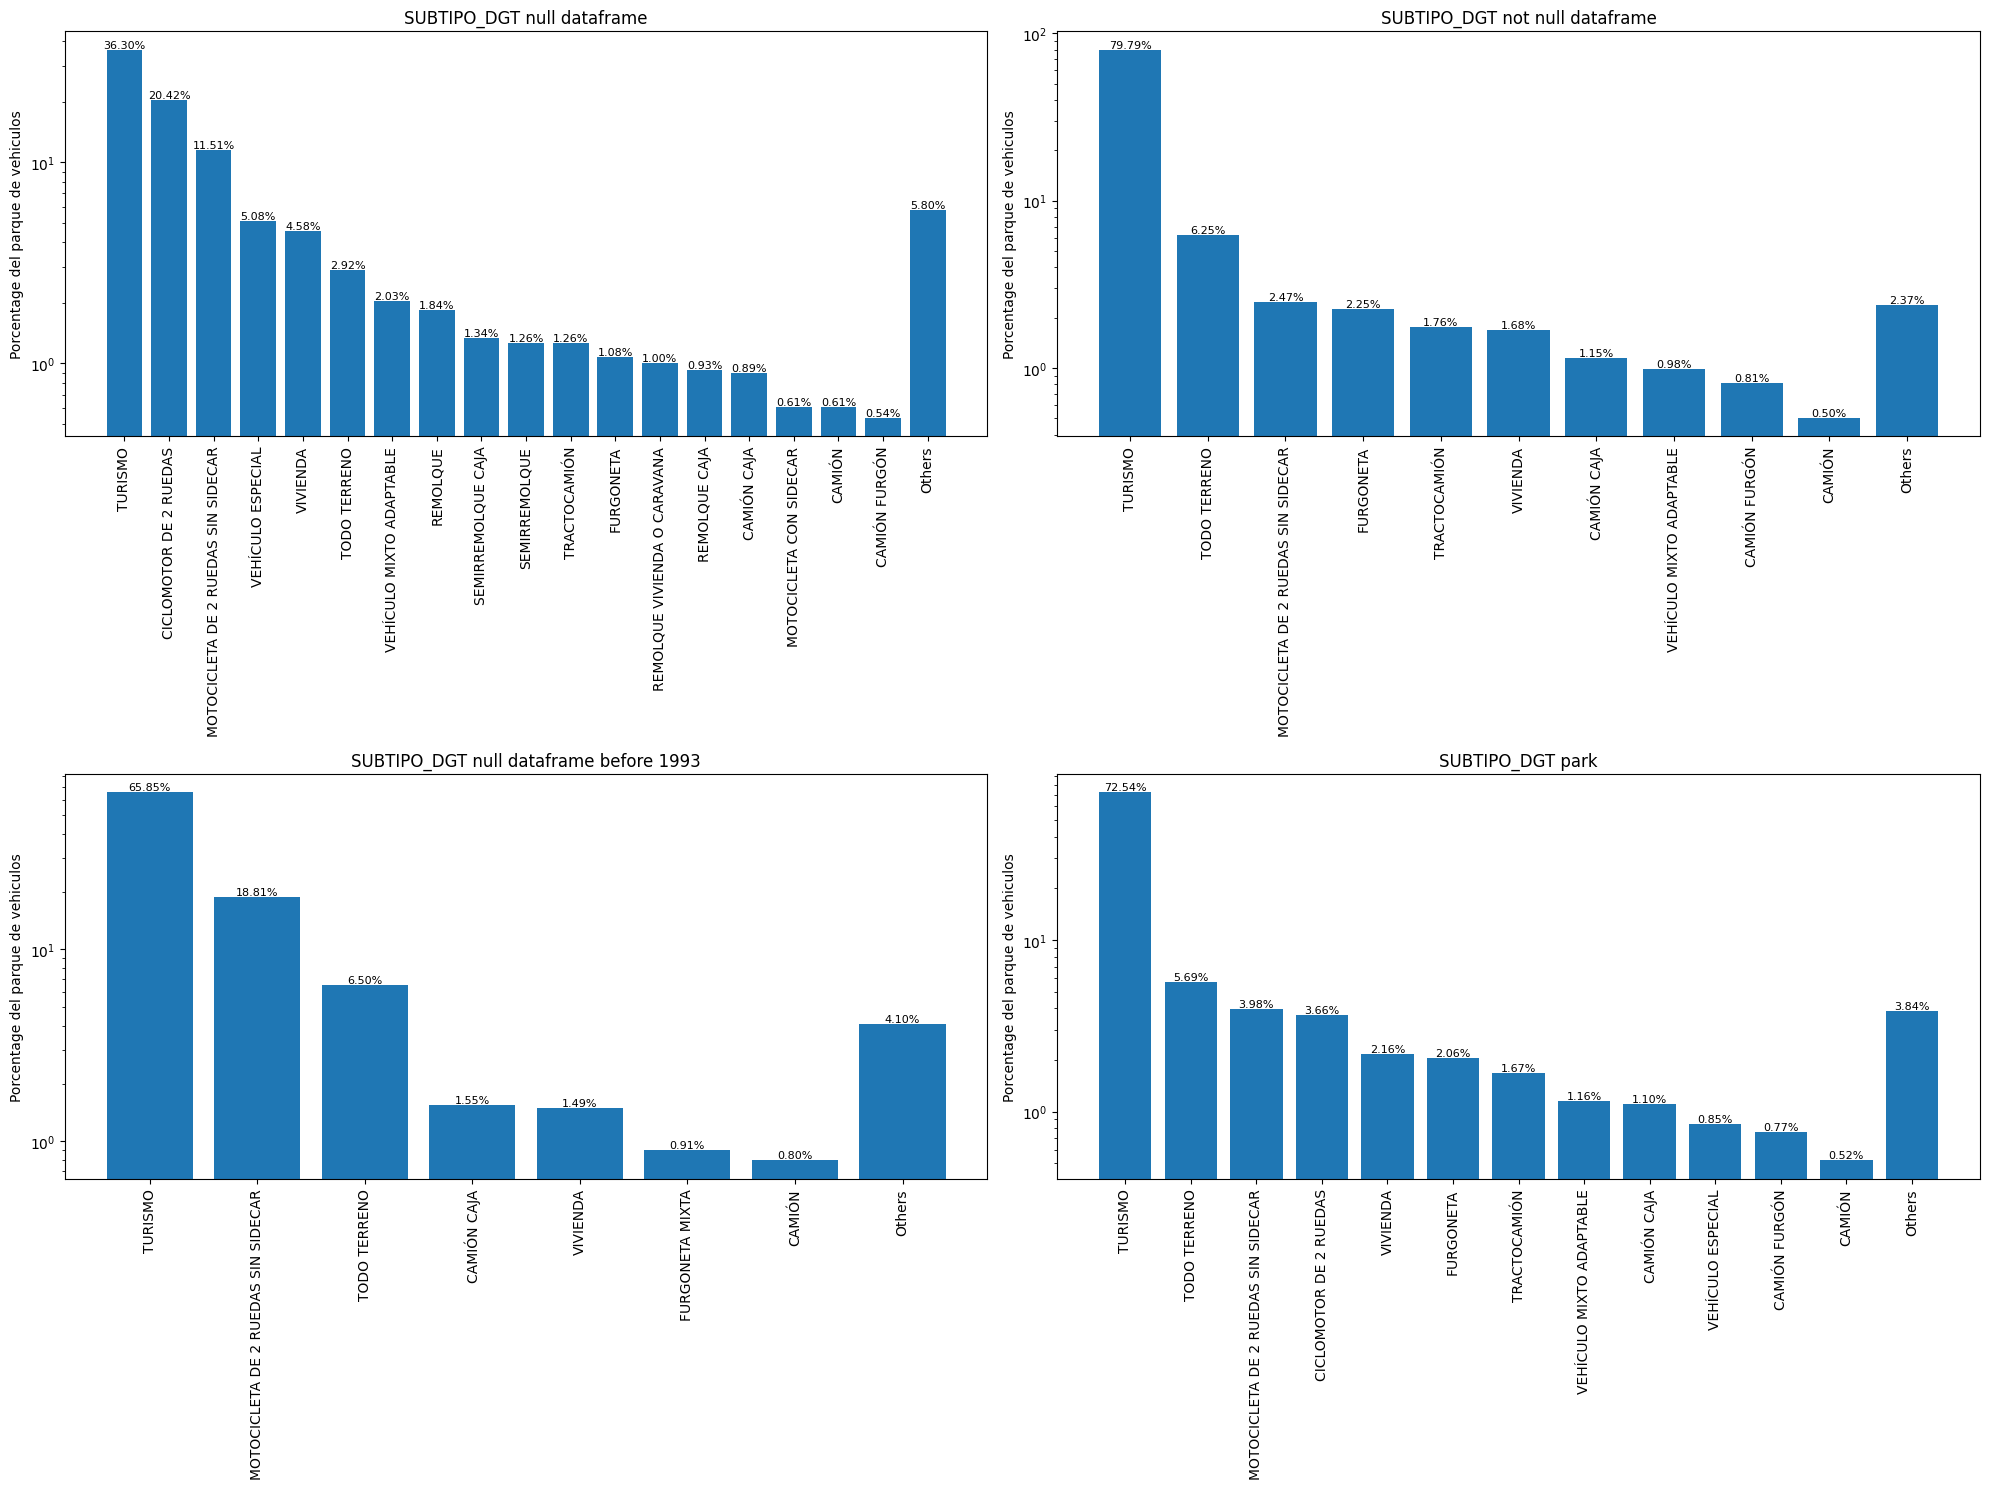

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

bar_plot(null_dataframe, 'SUBTIPO_DGT','SUBTIPO_DGT null dataframe', axes[0,0],0.49)
bar_plot(not_null_dataframe, 'SUBTIPO_DGT','SUBTIPO_DGT not null dataframe', axes[0,1],0.49)
bar_plot(park, 'SUBTIPO_DGT','SUBTIPO_DGT park', axes[1,1],0.49)
bar_plot(null_dataframe.filter(pl.col('FECHA_MATR').dt.year() < 1993), 'SUBTIPO_DGT',
         'SUBTIPO_DGT null dataframe before 1993', axes[1,0],0.49)

plt.tight_layout()
plt.show()

Bueno, los ciclomotores, remolque, semiremolque caja, remolque de vivienda o caravana, remolque caja, al aprecer, no presentan el dato de emisiones euro. tiene snetido. Hya que mirar mejor esto.

##### Remolques

Los remolques (y semiremolques), por definicion son vehiculos que no estan propulsados, por lo tanto, no presentan emisiones. En todo caso, se podria añadir un extra de emisiones por cada remolque debido a que arrastrarlos provoca un mayor consumo, aunque a lo mejor esto se podria añadir en el modelo de Movilidad para afinar el modelo

Vamos a: 
- Asegurarnos que no tienen motor leyendo las columans de motor y tal (Columans a añadir:)
    - 8  | CILINDRADA | Cilindrada del vehículo. Unidad: cm3. | INTEGER 
    - 29 | POTENCIA   | Potencia fiscal. Unidad: CVF.         | DECIMAL(5,2) 
    - 30 | KW         | Potencia del motor. Unidad: Kw.       | DECIMAL(5,2)
- Añadirles una categoria de EMISIONES_EURO especial "NO_EMISIONES".

In [ ]:
columns= ['FECHA_MATR','FECHA_PRIM_MATR','EMISIONES_CO2','EMISIONES_EURO',
          'SUBTIPO_DGT','PROPULSION','CLASE_MATR','ALIMENTACION','CATELECT',
          'CONSUMO','PROVINCIA_MATR','CILINDRADA','POTENCIA','KW']

schema_park = {'FECHA_MATR': pl.Date,
               'FECHA_PRIM_MATR': pl.Date,
               'EMISIONES_CO2': pl.Float64,
               'EMISIONES_EURO': pl.String,
               'SUBTIPO_DGT': pl.String,
               'PROPULSION': pl.String,
               'CLASE_MATR': pl.String,
               'ALIMENTACION': pl.String,
               'CATELECT': pl.String,
               'CONSUMO': pl.Float64,
               'PROVINCIA_MATR': pl.String,
               'CILINDRADA' : pl.Int64,
               'POTENCIA': pl.String,
               'KW': pl.String}

parque = pl.scan_csv(complete_park, separator='|', schema_overrides=schema_park).select(columns)
parque= parque.filter(pl.col("FECHA_MATR") > pl.col("FECHA_PRIM_MATR"))

park = parque.collect()
null_dataframe = park.filter(pl.col('EMISIONES_EURO').is_null())
not_null_dataframe = park.filter(pl.col('EMISIONES_EURO').is_not_null())

In [23]:
#Mapping de subtipo DGT
mapping = {
    "00": "CAMIÓN",
    "01": "CAMIÓN PLATAFORMA",
    "02": "CAMIÓN CAJA",
    "03": "CAMIÓN FURGÓN",
    "04": "CAMIÓN BOTELLERO",
    "05": "CAMIÓN CISTERNA",
    "06": "CAMIÓN JAULA",
    "07": "CAMIÓN FRIGORÍFICO",
    "08": "CAMIÓN TALLER",
    "09": "CAMIÓN PARA CANTERA",
    "0A": "CAMIÓN PORTAVEHÍCULOS",
    "0B": "CAMIÓN MIXTO",
    "0C": "CAMIÓN PORTACONTENEDORES",
    "0D": "CAMIÓN BASURERO",
    "0E": "CAMIÓN ISOTERMO",
    "0F": "CAMIÓN SILO",
    "0G": "VEHÍCULO MIXTO ADAPTABLE",
    "10": "CAMIÓN ARTICULADO",
    "11": "CAMIÓN ARTICULADO PLATAFORMA",
    "12": "CAMIÓN ARTICULADO CAJA",
    "13": "CAMIÓN ARTICULADO FURGÓN",
    "14": "CAMIÓN ARTICULADO BOTELLERO",
    "15": "CAMIÓN ARTICULADO CISTERNA",
    "16": "CAMIÓN ARTICULADO JAULA",
    "17": "CAMIÓN ARTICULADO FRIGORÍFICO",
    "18": "CAMIÓN ARTICULADO TALLER",
    "19": "CAMIÓN ARTICULADO PARA CANTERA",
    "1A": "CAMIÓN ARTICULADO VIVIENDA O CARAVANA",
    "1C": "CAMIÓN ARTICULADO HORMIGONERA",
    "1D": "CAMIÓN ARTICULADO VOLQUETE",
    "1E": "CAMIÓN ARTICULADO GRÚA",
    "1F": "CAMIÓN ARTICULADO CONTRA INCENDIOS",
    "20": "FURGONETA",
    "21": "FURGONETA MIXTA",
    "22": "AMBULANCIA",
    "23": "COCHE FÚNEBRE",
    "24": "CAMIONETA",
    "25": "TODO TERRENO",
    "30": "AUTOBÚS",
    "31": "AUTOBÚS ARTICULADO",
    "32": "AUTOBÚS MIXTO",
    "33": "BIBLIOBÚS",
    "34": "AUTOBÚS LABORATORIO",
    "35": "AUTOBÚS TALLER",
    "36": "AUTOBÚS SANITARIO",
    "40": "TURISMO",
    "50": "MOTOCICLETA DE 2 RUEDAS SIN SIDECAR",
    "51": "MOTOCICLETA CON SIDECAR",
    "52": "MOTOCARRO",
    "53": "AUTOMÓVIL DE 3 RUEDAS",
    "54": "CUATRICICLO PESADO",
    "60": "VEHÍCULO DE MOVILIDAD PERSONAL",
    "70": "VEHÍCULO ESPECIAL",
    "71": "PALA CARGADORA",
    "72": "PALA EXCAVADORA",
    "73": "CARRETILLA ELEVADORA",
    "74": "MONIVELADORA",
    "75": "COMPACTADORA",
    "76": "APISONADORA",
    "77": "GIROGRAVILLADORA",
    "78": "MACHACADORA",
    "79": "QUITANIEVES",
    "7A": "VIVIENDA",
    "7B": "BARREDORA",
    "7C": "HORMIGONERA",
    "7D": "VOLQUETE DE CANTERAS",
    "7E": "GRÚA",
    "7F": "SERVICIO CONTRA INCENDIOS",
    "7G": "ASPIRADORA DE FANGOS",
    "7H": "MOTOCULTOR",
    "7I": "MAQUINARIA AGRÍCOLA AUTOMOTRIZ",
    "7J": "PALA CARGADORA-RETROEXCAVADORA",
    "7K": "TREN HASTA 160 PLAZAS",
    "80": "TRACTOR",
    "81": "TRACTOCAMIÓN",
    "82": "TRACTOCARRO",
    "90": "CICLOMOTOR DE 2 RUEDAS",
    "91": "CICLOMOTOR DE 3 RUEDAS",
    "92": "CUATRICICLO LIGERO",
    "EX": "EXTRANJERO",
    "R0": "REMOLQUE",
    "R1": "REMOLQUE PLATAFORMA",
    "R2": "REMOLQUE CAJA",
    "R3": "REMOLQUE FURGÓN",
    "R4": "REMOLQUE BOTELLERO",
    "R5": "REMOLQUE CISTERNA",
    "R6": "REMOLQUE JAULA",
    "R7": "REMOLQUE FRIGORÍFICO",
    "R8": "REMOLQUE TALLER",
    "R9": "REMOLQUE PARA CANTERAS",
    "RA": "REMOLQUE VIVIENDA O CARAVANA",
    "RB": "REMOLQUE DE VIAJEROS O DE AUTOBÚS",
    "RC": "REMOLQUE HORMIGONERA",
    "RD": "REMOLQUE VOLQUETE DE CANTERA",
    "RE": "REMOLQUE DE GRÚA",
    "RF": "REMOLQUE CONTRA INCENDIOS",
    "RH": "MAQ.AGRÍCOLA ARRASTRADA DE 2 EJES",
    "S0": "SEMIRREMOLQUE",
    "S1": "SEMIRREMOLQUE PLATAFORMA",
    "S2": "SEMIRREMOLQUE CAJA",
    "S3": "SEMIRREMOLQUE FURGÓN",
    "s3": "SEMIRREMOLQUE FURGÓN",
    "S4": "SEMIRREMOLQUE BOTELLERO",
    "S5": "SEMIRREMOLQUE CISTERNA",
    "S6": "SEMIRREMOLQUE JAULA",
    "S7": "SEMIRREMOLQUE FRIGORÍFICO",
    "S8": "SEMIRREMOLQUE TALLER",
    "S9": "SEMIRREMOLQUE CANTERA",
    "SA": "SEMIRREMOLQUE VIVIENDA O CARAVANA",
    "SB": "SEMIRREMOLQUE VIAJEROS O AUTOBÚS",
    "SC": "SEMIRREMOLQUE HORMIGONERA",
    "SD": "SEMIRREMOLQUE VOLQUETE DE CANTERA",
    "SE": "SEMIRREMOLQUE GRÚA",
    "SF": "SEMIRREMOLQUE CONTRA INCENDIOS",
    "SH": "MAQ.AGRÍCOLA ARRASTRADA DE 1 EJE",
    "": "SIN ESPECIFICAR"
}
park = park.with_columns(
    pl.col('SUBTIPO_DGT').cast(pl.Utf8).replace(mapping).alias("SUBTIPO_DGT")
    )

In [31]:
lista = park['SUBTIPO_DGT'].value_counts().sort('count', descending=True).get_column('SUBTIPO_DGT').to_list()
remolques = []
for vehiculo in lista:
    if 'REMOLQUE' in vehiculo: 
        remolques.append(vehiculo)
remolques_dataframes = park.filter(pl.col('SUBTIPO_DGT').is_in(remolques))

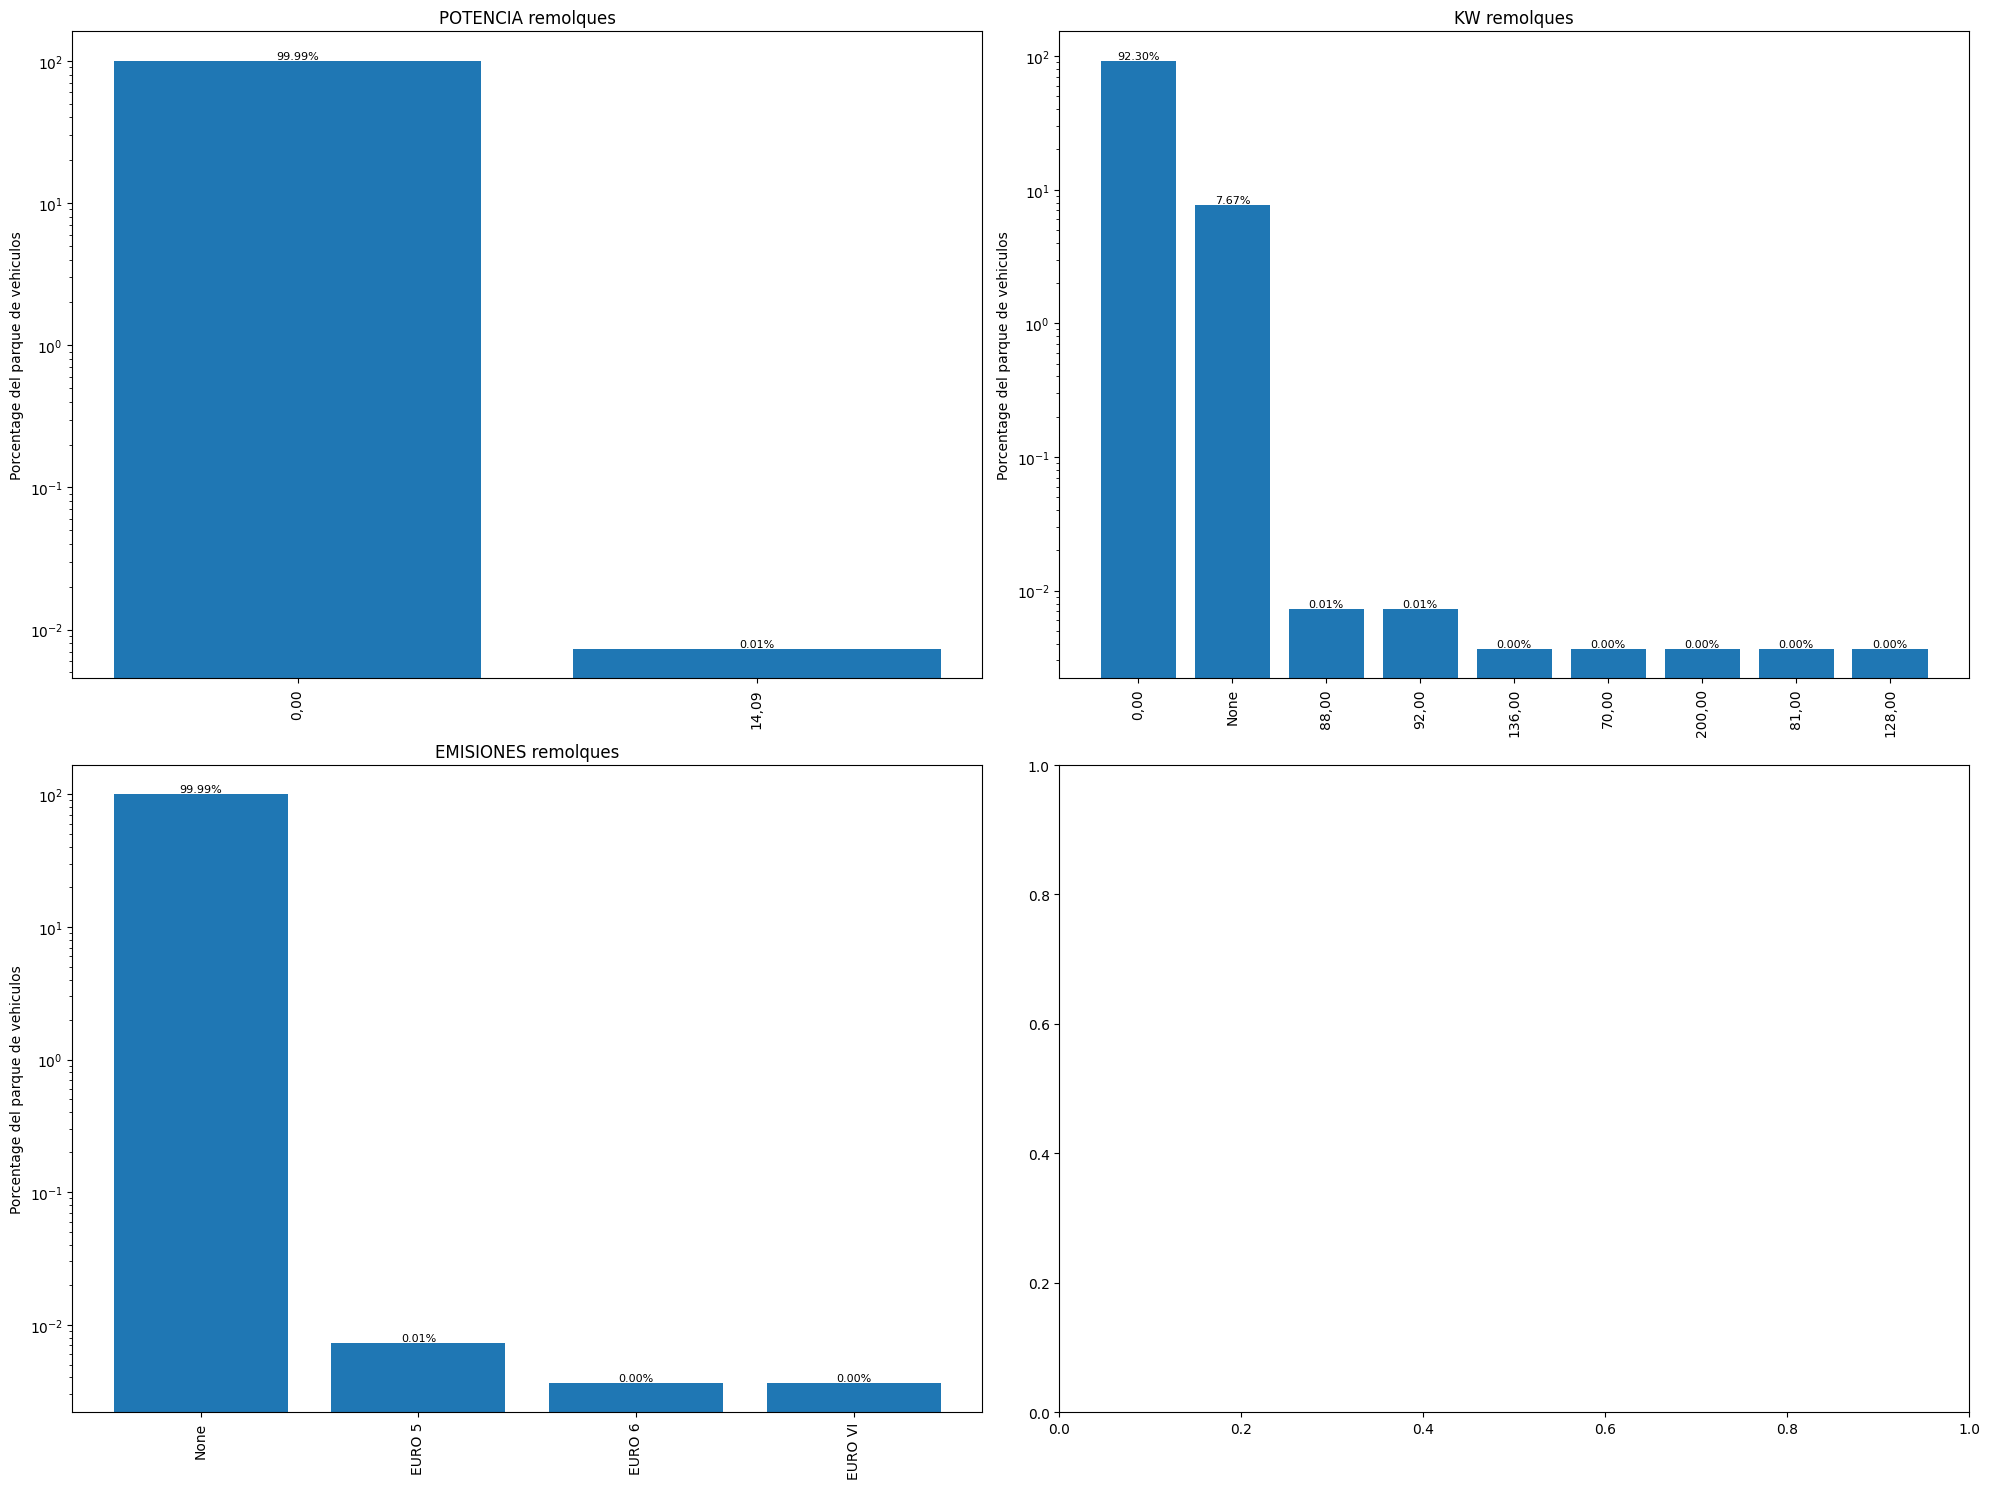

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

bar_plot(remolques_dataframes, 'POTENCIA','POTENCIA remolques', axes[0,0], 0)
bar_plot(remolques_dataframes, 'KW','KW remolques', axes[0,1], 0)
bar_plot(remolques_dataframes, 'EMISIONES_EURO','EMISIONES remolques', axes[1,0], 0)

plt.tight_layout()
plt.show()
#Hay algunos que no tienen la CLASE_MATR como remolque porqué son vehiculos especiales o históricos 
# pero siguen siendo remolques y, por lo tanto, sin motor

La gran mayoria de remolques no tienen motor, por lo tanto, si podriamos considerar que no tienen emisiones asi que, releemos el csv simplificado y cambiamos la columna de EMISIONES_EURO para reescribir el fichero

In [42]:
park = pl.scan_csv(filtered_park, schema = schema_park)
park = park.collect()

mapping = {
    "0": "Ordinaria",
    "2": "Remolque",
    "3": "Diplomática",
    "5": "Vehículo especial",
    "6": "Ciclomotor",
    "8": "Histórica"
    }
park = park.with_columns(
    pl.col('CLASE_MATR').cast(pl.Utf8).replace(mapping).alias("CLASE_MATR")
    )
mapping = {
    "0": "Gasolina",
    "1": "Diésel",
    "2": "Eléctrico",
    "3": "Otros",
    "4": "Buatno",
    "5": "Solar",
    "6": "Gas licuado de Petróleo",
    "7": "Gas Natural Comprimido",
    "8": "Gas Natural Licuado",
    "9": "Hidrógeno",
    "A": "Biometano",
    "B": "Etanol",
    "C": "Biodiesel",
    "D": "Diésel",
    "G": "Gasolina",
}

park = park.with_columns(
    pl.col('PROPULSION').cast(pl.Utf8).replace(mapping).alias("PROPULSION")
)

mapping = {
    "00": "CAMIÓN",
    "01": "CAMIÓN PLATAFORMA",
    "02": "CAMIÓN CAJA",
    "03": "CAMIÓN FURGÓN",
    "04": "CAMIÓN BOTELLERO",
    "05": "CAMIÓN CISTERNA",
    "06": "CAMIÓN JAULA",
    "07": "CAMIÓN FRIGORÍFICO",
    "08": "CAMIÓN TALLER",
    "09": "CAMIÓN PARA CANTERA",
    "0A": "CAMIÓN PORTAVEHÍCULOS",
    "0B": "CAMIÓN MIXTO",
    "0C": "CAMIÓN PORTACONTENEDORES",
    "0D": "CAMIÓN BASURERO",
    "0E": "CAMIÓN ISOTERMO",
    "0F": "CAMIÓN SILO",
    "0G": "VEHÍCULO MIXTO ADAPTABLE",
    "10": "CAMIÓN ARTICULADO",
    "11": "CAMIÓN ARTICULADO PLATAFORMA",
    "12": "CAMIÓN ARTICULADO CAJA",
    "13": "CAMIÓN ARTICULADO FURGÓN",
    "14": "CAMIÓN ARTICULADO BOTELLERO",
    "15": "CAMIÓN ARTICULADO CISTERNA",
    "16": "CAMIÓN ARTICULADO JAULA",
    "17": "CAMIÓN ARTICULADO FRIGORÍFICO",
    "18": "CAMIÓN ARTICULADO TALLER",
    "19": "CAMIÓN ARTICULADO PARA CANTERA",
    "1A": "CAMIÓN ARTICULADO VIVIENDA O CARAVANA",
    "1C": "CAMIÓN ARTICULADO HORMIGONERA",
    "1D": "CAMIÓN ARTICULADO VOLQUETE",
    "1E": "CAMIÓN ARTICULADO GRÚA",
    "1F": "CAMIÓN ARTICULADO CONTRA INCENDIOS",
    "20": "FURGONETA",
    "21": "FURGONETA MIXTA",
    "22": "AMBULANCIA",
    "23": "COCHE FÚNEBRE",
    "24": "CAMIONETA",
    "25": "TODO TERRENO",
    "30": "AUTOBÚS",
    "31": "AUTOBÚS ARTICULADO",
    "32": "AUTOBÚS MIXTO",
    "33": "BIBLIOBÚS",
    "34": "AUTOBÚS LABORATORIO",
    "35": "AUTOBÚS TALLER",
    "36": "AUTOBÚS SANITARIO",
    "40": "TURISMO",
    "50": "MOTOCICLETA DE 2 RUEDAS SIN SIDECAR",
    "51": "MOTOCICLETA CON SIDECAR",
    "52": "MOTOCARRO",
    "53": "AUTOMÓVIL DE 3 RUEDAS",
    "54": "CUATRICICLO PESADO",
    "60": "VEHÍCULO DE MOVILIDAD PERSONAL",
    "70": "VEHÍCULO ESPECIAL",
    "71": "PALA CARGADORA",
    "72": "PALA EXCAVADORA",
    "73": "CARRETILLA ELEVADORA",
    "74": "MONIVELADORA",
    "75": "COMPACTADORA",
    "76": "APISONADORA",
    "77": "GIROGRAVILLADORA",
    "78": "MACHACADORA",
    "79": "QUITANIEVES",
    "7A": "VIVIENDA",
    "7B": "BARREDORA",
    "7C": "HORMIGONERA",
    "7D": "VOLQUETE DE CANTERAS",
    "7E": "GRÚA",
    "7F": "SERVICIO CONTRA INCENDIOS",
    "7G": "ASPIRADORA DE FANGOS",
    "7H": "MOTOCULTOR",
    "7I": "MAQUINARIA AGRÍCOLA AUTOMOTRIZ",
    "7J": "PALA CARGADORA-RETROEXCAVADORA",
    "7K": "TREN HASTA 160 PLAZAS",
    "80": "TRACTOR",
    "81": "TRACTOCAMIÓN",
    "82": "TRACTOCARRO",
    "90": "CICLOMOTOR DE 2 RUEDAS",
    "91": "CICLOMOTOR DE 3 RUEDAS",
    "92": "CUATRICICLO LIGERO",
    "EX": "EXTRANJERO",
    "R0": "REMOLQUE",
    "R1": "REMOLQUE PLATAFORMA",
    "R2": "REMOLQUE CAJA",
    "R3": "REMOLQUE FURGÓN",
    "R4": "REMOLQUE BOTELLERO",
    "R5": "REMOLQUE CISTERNA",
    "R6": "REMOLQUE JAULA",
    "R7": "REMOLQUE FRIGORÍFICO",
    "R8": "REMOLQUE TALLER",
    "R9": "REMOLQUE PARA CANTERAS",
    "RA": "REMOLQUE VIVIENDA O CARAVANA",
    "RB": "REMOLQUE DE VIAJEROS O DE AUTOBÚS",
    "RC": "REMOLQUE HORMIGONERA",
    "RD": "REMOLQUE VOLQUETE DE CANTERA",
    "RE": "REMOLQUE DE GRÚA",
    "RF": "REMOLQUE CONTRA INCENDIOS",
    "RH": "MAQ.AGRÍCOLA ARRASTRADA DE 2 EJES",
    "S0": "SEMIRREMOLQUE",
    "S1": "SEMIRREMOLQUE PLATAFORMA",
    "S2": "SEMIRREMOLQUE CAJA",
    "S3": "SEMIRREMOLQUE FURGÓN",
    "s3": "SEMIRREMOLQUE FURGÓN",
    "S4": "SEMIRREMOLQUE BOTELLERO",
    "S5": "SEMIRREMOLQUE CISTERNA",
    "S6": "SEMIRREMOLQUE JAULA",
    "S7": "SEMIRREMOLQUE FRIGORÍFICO",
    "S8": "SEMIRREMOLQUE TALLER",
    "S9": "SEMIRREMOLQUE CANTERA",
    "SA": "SEMIRREMOLQUE VIVIENDA O CARAVANA",
    "SB": "SEMIRREMOLQUE VIAJEROS O AUTOBÚS",
    "SC": "SEMIRREMOLQUE HORMIGONERA",
    "SD": "SEMIRREMOLQUE VOLQUETE DE CANTERA",
    "SE": "SEMIRREMOLQUE GRÚA",
    "SF": "SEMIRREMOLQUE CONTRA INCENDIOS",
    "SH": "MAQ.AGRÍCOLA ARRASTRADA DE 1 EJE",
    "": "SIN ESPECIFICAR"
}
park = park.with_columns(
    pl.col('SUBTIPO_DGT').cast(pl.Utf8).replace(mapping).alias("SUBTIPO_DGT")
    )

mapping = {
    "01": "Araba/Álava",
    "02": "Albacete",
    "03": "Alicante/Alacant",
    "04": "Almería",
    "05": "Ávila",
    "06": "Badajoz",
    "07": "Balears (Illes)",
    "08": "Barcelona",
    "09": "Burgos",
    "1": "Araba/Álava",
    "2": "Albacete",
    "3": "Alicante/Alacant",
    "4": "Almería",
    "5": "Ávila",
    "6": "Badajoz",
    "7": "Balears (Illes)",
    "8": "Barcelona",
    "9": "Burgos",
    "10": "Cáceres",
    "11": "Cádiz",
    "12": "Castellón/Castelló",
    "13": "Ciudad Real",
    "14": "Córdoba",
    "15": "Coruña (A)",
    "16": "Cuenca",
    "17": "Girona",
    "18": "Granada",
    "19": "Guadalajara",
    "20": "Gipuzkoa",
    "21": "Huelva",
    "22": "Huesca",
    "23": "Jaén",
    "24": "León",
    "25": "Lleida",
    "26": "Rioja (La)",
    "27": "Lugo",
    "28": "Madrid",
    "29": "Málaga",
    "30": "Murcia",
    "31": "Navarra",
    "32": "Ourense",
    "33": "Asturias",
    "34": "Palencia",
    "35": "Palmas (Las)",
    "36": "Pontevedra",
    "37": "Salamanca",
    "38": "Santa Cruz de Tenerife",
    "39": "Cantabria",
    "40": "Segovia",
    "41": "Sevilla",
    "42": "Soria",
    "43": "Tarragona",
    "44": "Teruel",
    "45": "Toledo",
    "46": "Valencia/València",
    "47": "Valladolid",
    "48": "Bizkaia",
    "49": "Zamora",
    "50": "Zaragoza",
    "51": "Ceuta",
    "52": "Melilla",
    "99": "Extranjero",
    "100": "Desconocido"
}
park = park.with_columns(
    pl.col('PROVINCIA_MATR').cast(pl.Utf8).replace(mapping).alias("PROVINCIA_MATR")
    )

In [44]:
park = park.with_columns(
    pl.when((pl.col("SUBTIPO_DGT").is_in(remolques)) |
            (pl.col('CLASE_MATR') == "Remolque"))
    .then(pl.lit("NO_EMISIONS"))
    .otherwise(pl.col("EMISIONES_EURO"))
    .alias("EMISIONES_EURO")
)

park.write_csv(filtered_park)
null_dataframe = park.filter(pl.col('EMISIONES_EURO').is_null())
not_null_dataframe = park.filter(pl.col('EMISIONES_EURO').is_not_null())

Vamos a contar cuantos de estos salen en null y cuantos salen en no null.
Podriamos hacerlo al revés, mirar los que salgan menos (o no salgan) en not null y parque y mirar si tienen muchos nulls (habria que mirar si alguno es exclusivo en null)

Ahora que hemos filtrado estos datos (27.000) hay que volver a analizar lo hehco hasta ahora.

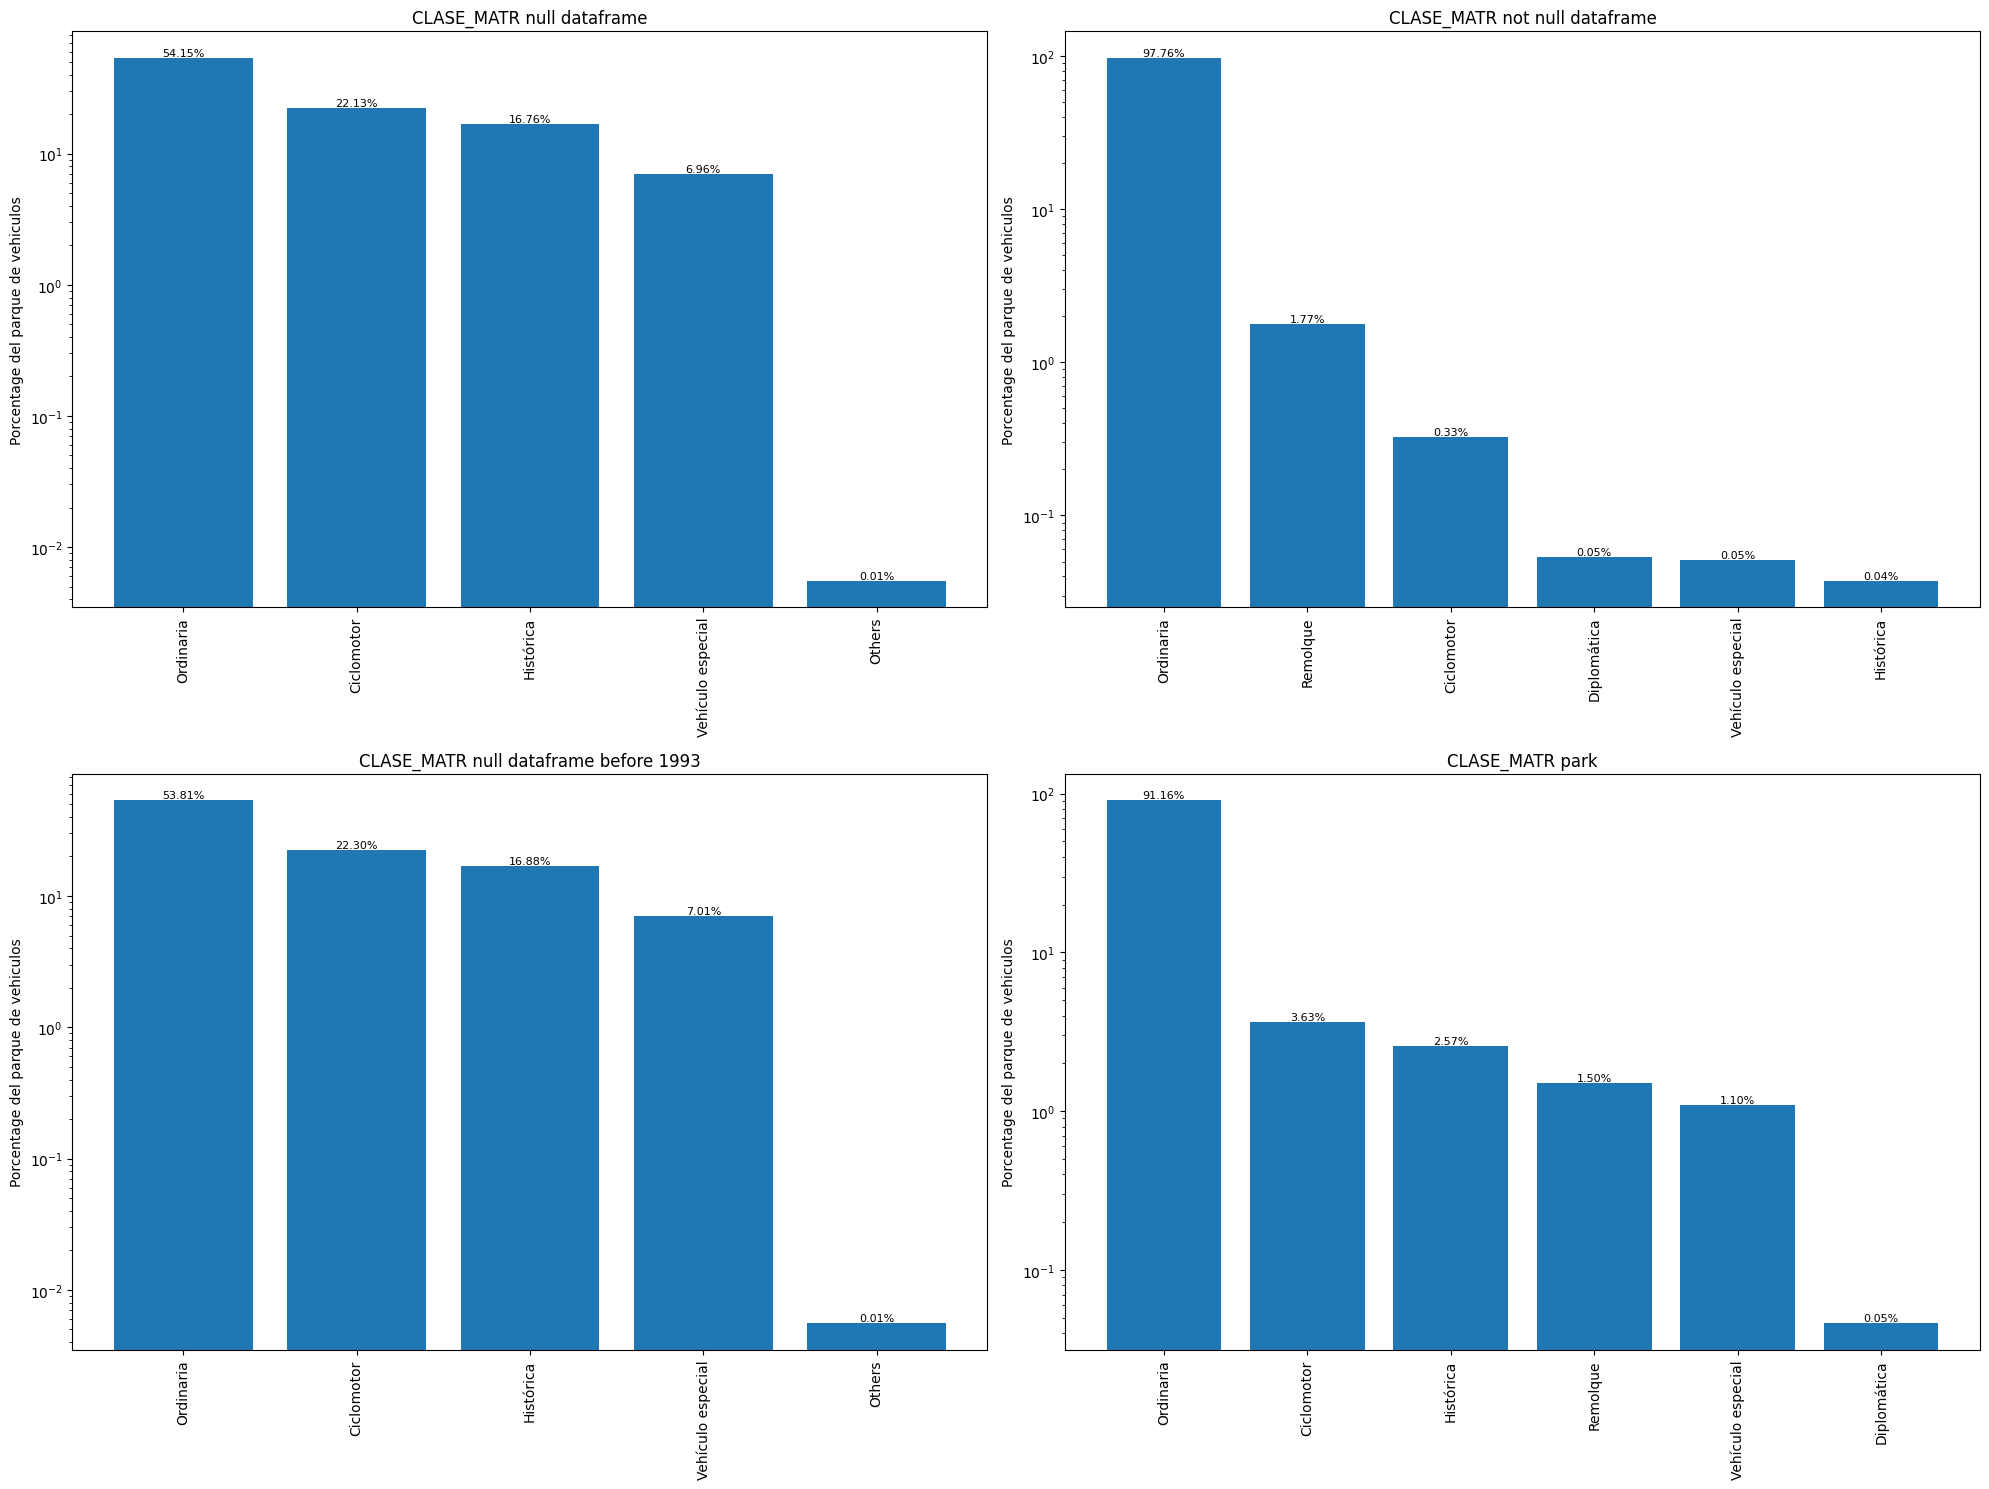

In [361]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

bar_plot(null_dataframe, 'CLASE_MATR','CLASE_MATR null dataframe', axes[0,0])
bar_plot(not_null_dataframe, 'CLASE_MATR','CLASE_MATR not null dataframe', axes[0,1])
bar_plot(park, 'CLASE_MATR','CLASE_MATR park', axes[1,1])
bar_plot(null_dataframe.filter(pl.col('FECHA_MATR').dt.year() > 1993), 'CLASE_MATR',
         'CLASE_MATR null dataframe before 1993', axes[1,0])

plt.tight_layout()
plt.show()

In [391]:
provinulo = null_dataframe['PROVINCIA_MATR']
provinulo.value_counts().sort('count', descending=True)

PROVINCIA_MATR,count
str,u32
"""Madrid""",27467
null,22878
"""Ávila""",19644
"""Araba/Álava""",16146
"""Málaga""",13086
…,…
"""Castellón/Castelló""",500
"""Palmas (Las)""",494
"""Soria""",452


In [380]:
ciclo = null_dataframe.filter((pl.col('CLASE_MATR') == 'Ciclomotor')) #&
#                      (pl.col('SUBTIPO_DGT') == 'CICLOMOTOR DE 2 RUEDAS'))
ciclo["SUBTIPO_DGT"].value_counts().sort('count', descending=True)

SUBTIPO_DGT,count
str,u32
"""CICLOMOTOR DE 2 RUEDAS""",59355
"""CUATRICICLO LIGERO""",840
"""CICLOMOTOR DE 3 RUEDAS""",40
"""MOTOCARRO""",3
"""MOTOCICLETA DE 2 RUEDAS SIN SI…",1


#### Por Propulsion

La unica diferencia aparente es que en los nulls no encontramos tantos "25" como en el dataset completo, 25 son todoterrnos. 
Voy a buscar en Propulsion

In [125]:
null_dataframe['PROPULSION'].value_counts().sort('count', descending=True)

PROPULSION,count
str,u32
"""Gasolina""",195412
"""Diésel""",71877
null,28583
"""Eléctrico""",3398
"""Gas licuado de Petróleo""",207
…,…
"""Biodiesel""",3
"""Biometano""",2
"""Etanol""",1


In [201]:
def bar_plot(dataframe, nombre_columna):
    values = dataframe[nombre_columna].value_counts().sort('count', descending=True).get_column('count').to_list()
    values_labels = dataframe[nombre_columna].value_counts().sort('count', descending=True).get_column(nombre_columna).to_list()

    for i,label in enumerate(values_labels):
        if label is None:
            values_labels[i] = 'None'

    others = 0
    percentages,labels = [],[]

    for i,value in enumerate(values):
        percentage = 100*value/sum(values)
        if percentage < 0.001:
            others += percentage
        else:
            percentages.append(percentage)
            labels.append(values_labels[i])

    percentages.append(others)
    labels.append('Others')

    fig, ax = plt.subplots()

    ax.bar(labels, percentages, log = True,)
    ax.set_ylabel('Porcentage del parque de vehiculos')
    ax.set_title('Tipo de propulsion')
    ax.set_xticklabels(labels, rotation=90)
    plt.show()

/var/folders/gk/9s2n71rj4fq128zrj3x599pr0000gn/T/ipykernel_751/933803814.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)


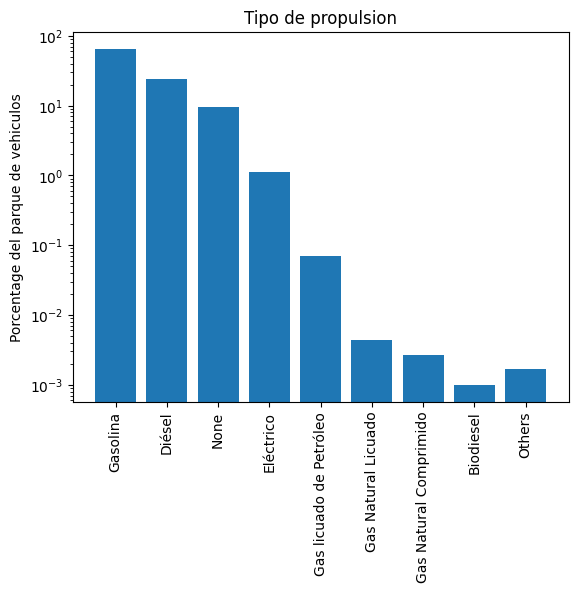

In [204]:
bar_plot(null_dataframe,'PROPULSION')

#### Por Alimentación

#### Por Provicnia o localidad
#### Por class utilizacion
#### Por tipo titular
#### Por cilindrada/potencia/motor
#### Por tara/peso maximo/peso util
#### Por procedencia
#### Por Fabricante
#### Por Marca
#### Por renting

------

In [110]:
park
emisiones_euro = []
for i in range(0,148):
    tipo = ((park.select('EMISIONES_EURO').unique().sort('EMISIONES_EURO')).row(i))[0]
    emisiones_euro.append(tipo)

In [111]:
[print(i) for i in emisiones_euro]

None
=4B
=IIIB
AX
EURO 1
EURO 2
EURO 3
EURO 4
EURO 5
EURO 5+
EURO 5A
EURO 5B
EURO 5CJ
EURO 5F
EURO 5G
EURO 5H
EURO 5I
EURO 5J
EURO 5K
EURO 5L
EURO 5M
EURO 5T
EURO 5V
EURO 5W
EURO 6
EURO 6 C
EURO 6 D
EURO 6 I
EURO 6(A
EURO 6A
EURO 6AA
EURO 6AB
EURO 6AC
EURO 6AD
EURO 6AE
EURO 6AF
EURO 6AG
EURO 6AH
EURO 6AI
EURO 6AJ
EURO 6AK
EURO 6AL
EURO 6AM
EURO 6AN
EURO 6AO
EURO 6AP
EURO 6AQ
EURO 6AR
EURO 6AX
EURO 6AZ
EURO 6B
EURO 6BA
EURO 6BB
EURO 6BC
EURO 6BG
EURO 6BH
EURO 6BI
EURO 6BY
EURO 6C
EURO 6CG
EURO 6CH
EURO 6CI
EURO 6DG
EURO 6EA
EURO 6J
EURO 6M
EURO 6N
EURO 6O
EURO 6P
EURO 6Q
EURO 6R
EURO 6T
EURO 6U
EURO 6W
EURO 6X
EURO 6Y
EURO 6Z
EURO 6ZA
EURO 6ZB
EURO 6ZC
EURO 6ZD
EURO 6ZE
EURO 6ZF
EURO 6ZG
EURO 6ZH
EURO 6ZI
EURO 6ZJ
EURO 6ZY
EURO 6ZZ
EURO AX
EURO AY
EURO AZ
EURO EE
EURO I
EURO II
EURO III
EURO IV
EURO V
EURO VI
EURO VIB
EURO VID
EURO VIE
EURO ZX
EURO ZY
EURO ZZ
EURO6-AA
EURO6-AD
EURO6-AG
EURO6-AM
EURO6-AO
EURO6-AP
EURO6-AQ
EURO6-AR
EURO6-BG
EURO6-BI
EURO6-CI
EURO6-DG
EURO6-X
EURO6-ZA
EURO

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [92]:
park.filter(pl.col("EMISIONES_EURO").is_null())

EMISIONES_CO2,EMISIONES_EURO,TIPO_DISTINTIVO,SUBTIPO_DGT,CAT_EURO,PROPULSION,CLASE_MATR,ALIMENTACION,CATELECT,CONSUMO
f64,str,str,str,str,str,i64,str,str,i64
null,null,"""SIN DISTINTIVO""","""7A""","""M1""","""1""",0,null,null,0
null,null,"""SIN DISTINTIVO""","""40""","""M1""","""0""",0,null,null,0
null,null,"""SIN DISTINTIVO""","""90""","""L1E""","""0""",6,null,null,0
null,null,"""SIN DISTINTIVO""","""90""","""L1E""","""0""",6,null,null,0
null,null,"""SIN DISTINTIVO""","""90""",null,"""0""",6,null,null,null
…,…,…,…,…,…,…,…,…,…
null,null,"""SIN DISTINTIVO""","""90""",null,"""0""",6,null,null,null
0.0,null,"""SIN DISTINTIVO""","""90""","""L1E""","""0""",8,"""M""",null,0
null,null,"""SIN DISTINTIVO""","""RA""",null,null,2,null,null,0


In [84]:
tramite.select('CATEGORÍA_HOMOLOGACION_EUROPEA_ITV').unique().sort('CATEGORÍA_HOMOLOGACION_EUROPEA_ITV')

CATEGORÍA_HOMOLOGACION_EUROPEA_ITV
str
""""""
"""*02"""
"""*03"""
"""*05"""
"""*06"""
…
"""T3"""
"""T3B"""
"""T4"""
